### Dataset Creation

This is the notebook to train the classification of Diabetic Retinography with CNNs

This notebook contains the following
1. Dataset Creation and Augmentation
2. Train and Eval Functions
3. CNN Class Models (InceptionV3, ResNet50, ResNet152, EfficientNet, DenseNet, VGG16, MaxViT)

This notebook assumes the following project structure:
```bash
Root
├── notebooks
│   └── notebook1.ipynb
└── input
    └── Data
        ├── DDR
        │   ├── Train
        │   └── Test
        ── BEN
        │   ├── Train
        │   └── Test
        ├── CLAHE
        │   ├── Train
        │   └── Test
        ├── UNET_Binary
        │   ├── Train
        │   └── Test
        └── UNET_Multiclass
            ├── Train
            └── Test
```

If you do not have the dataset, please download it from our Google Drive

In [25]:
#Necessary Imports
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

### Dataset Creation

In [26]:
# Parameter required
image_size = (299,299)
batch_size = 64

# Defining Train Transforms
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with a 50% probability
    transforms.RandomVerticalFlip(p=0.5),  # Flip vertically with a 50% probability
    transforms.RandomAffine(
        degrees=360,  # Rotation
        translate=(0.1, 0.1),  # Translation
        scale=(0.8, 1.2) #Zooming
    ),
    transforms.ToTensor()
])


# Defining Evaluation Transforms, no data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

#### Ben Graham dataset

In [27]:
# Create PyTorch datasets for training and validation
ben_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/train', 
                    transform=train_transform
                    )
ben_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/val', 
                    transform=eval_transform
                    )
ben_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
ben_train_dataloader = torch.utils.data.DataLoader(
                    ben_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_val_dataloader = torch.utils.data.DataLoader(
                    ben_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_test_dataloader = torch.utils.data.DataLoader(
                    ben_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### CLAHE dataset

In [28]:
# Create PyTorch datasets for training and validation
clahe_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/train', 
                    transform=train_transform
                    )
clahe_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/val', 
                    transform=eval_transform
                    )
clahe_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
clahe_train_dataloader = torch.utils.data.DataLoader(
                    clahe_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_val_dataloader = torch.utils.data.DataLoader(
                    clahe_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_test_dataloader = torch.utils.data.DataLoader(
                    clahe_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Binary Dataset

In [29]:
# Create PyTorch datasets for training and validation
unetb_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/train', 
                    transform=train_transform
                    )
unetb_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/val', 
                    transform=eval_transform
                    )
unetb_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetb_train_dataloader = torch.utils.data.DataLoader(
                    unetb_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_val_dataloader = torch.utils.data.DataLoader(
                    unetb_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_test_dataloader = torch.utils.data.DataLoader(
                    unetb_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Multiclass Dataset

In [30]:
# Create PyTorch datasets for training and validation
unetm_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/train', 
                    transform=train_transform
                    )
unetm_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/val', 
                    transform=eval_transform
                    )
unetm_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetm_train_dataloader = torch.utils.data.DataLoader(
                    unetm_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_val_dataloader = torch.utils.data.DataLoader(
                    unetm_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_test_dataloader = torch.utils.data.DataLoader(
                    unetm_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### Visualisation

In [31]:
def visualise_img(dataloader, class_list: list):
    """
    Function to visualize the first 9 images of the dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_list (list): List of class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_list[label]}', loc='left')

    plt.tight_layout()
    plt.show()

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


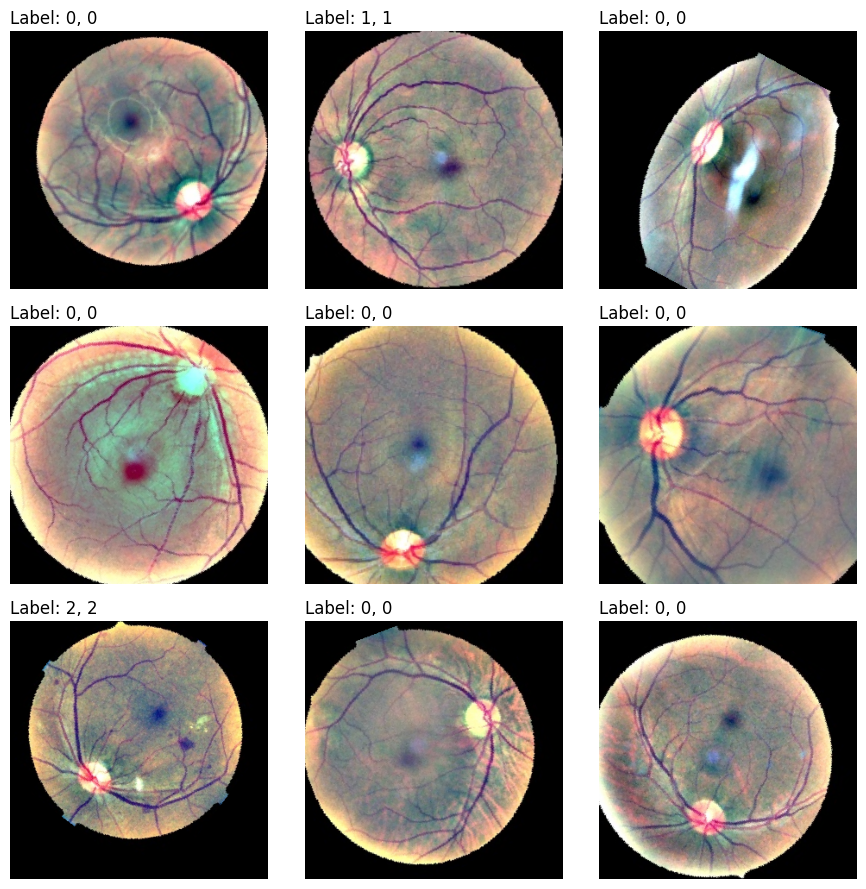

In [32]:
visualise_img(ben_train_dataloader, ben_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


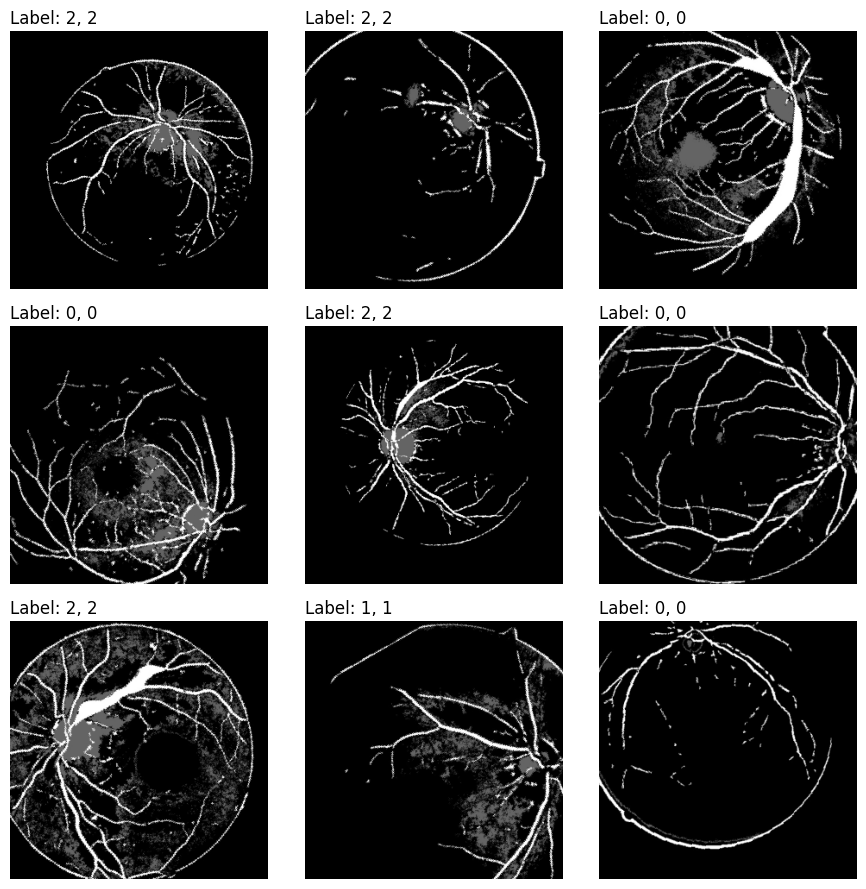

In [33]:
visualise_img(clahe_train_dataloader, clahe_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


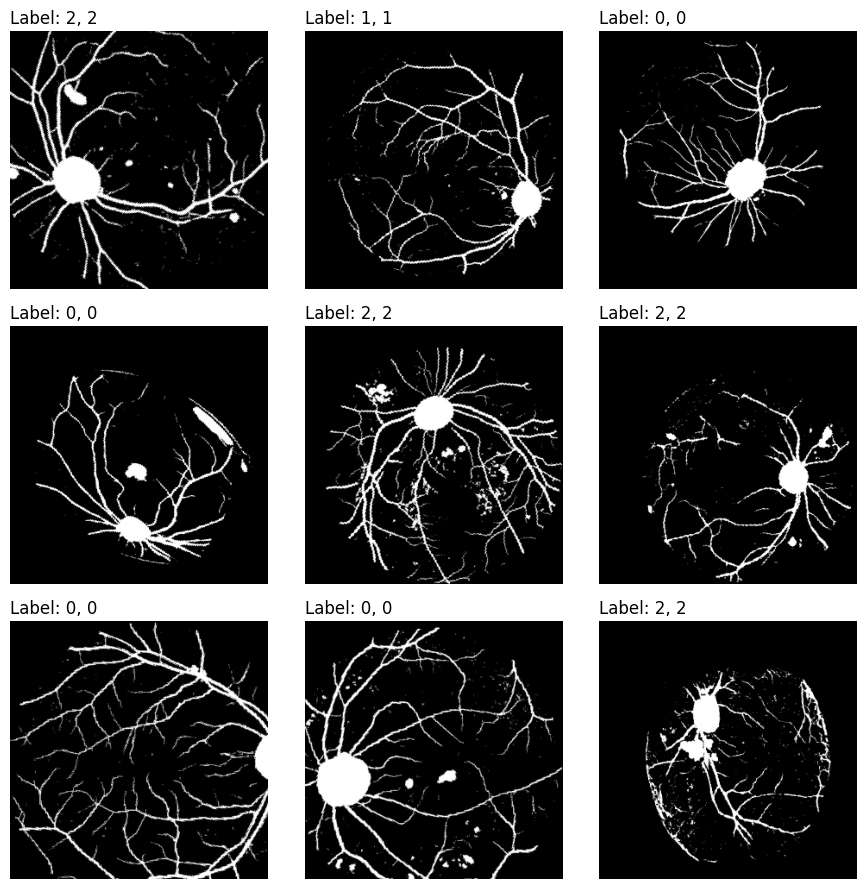

In [34]:
visualise_img(unetb_train_dataloader, unetb_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


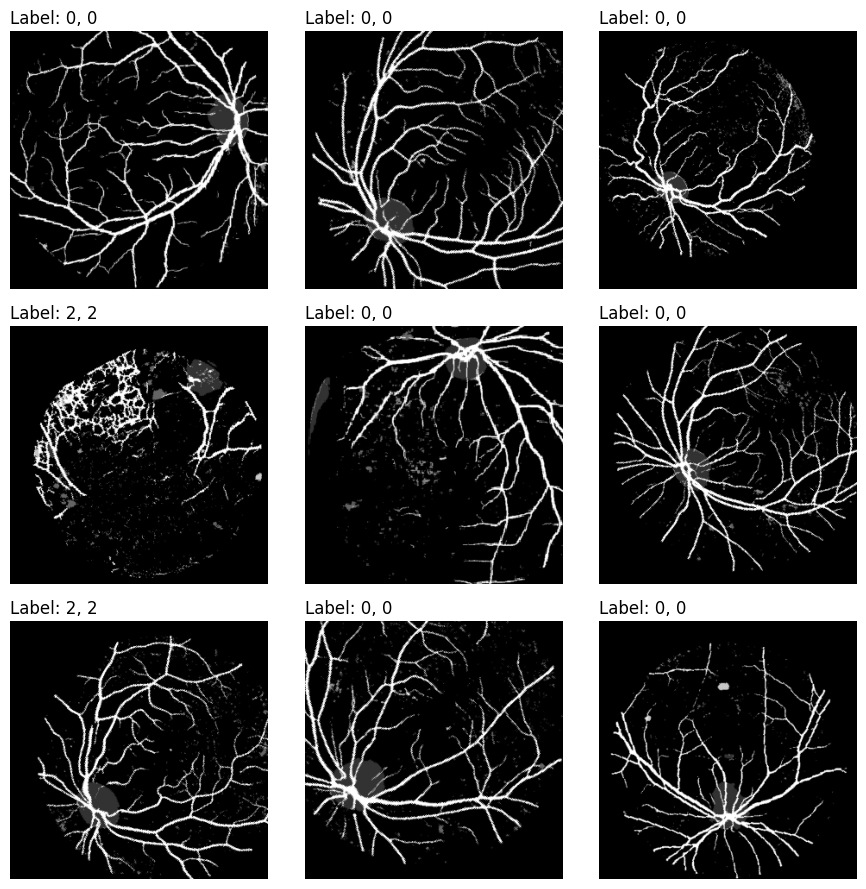

In [35]:
visualise_img(unetm_train_dataloader, unetm_train_dataset.classes)

### Train, Eval Functions

In [36]:
def calculate_dr_class_weights(dataset):
    """
    Function to calculate class weights
    Class Weights of i = Total Num of Samples / Total Num of samples of Class i * Num of classes

    We calculate the average of samples per class if it was equally distributed and then calculate the class weights based on the difference of actual vs ideal

    Args:
        dataset: train dataset

    Returns:
        weights (np.ndarray): array of size n_classes with the weights of each class in each index
    """
    # Counting the number of samples in each class
    class_counts = np.bincount(dataset.targets)
    total_samples = sum(class_counts)
    num_classes = len(class_counts)
    
    # Calculating class weights inversely proportional to the number of samples in each class
    weights = total_samples / (num_classes * class_counts)

    print("Class Weights:", weights)
    
    return weights

In [37]:
import torch

def eval(model, 
         criterion, 
         img_size:tuple,
         val_dataloader, 
         device='cuda'):
    """
    Evaluation function for finetuning CNN models with a model object,
    incorporating average sensitivity for a multiclass problem.

    Sensitivity function: True Positives / (True Positives + False Negatives)

    Args:
        model: model to be trained
        criterion: loss function
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        val_dataloader: val / test dataloader
        device (str, optional): 'cpu' or 'cuda', defaults to cuda.

    Returns:
        val_loss: float of the average val loss.
        val_accuracy: float of the accuracy.
        val_sensitivity: float of the average sensitivity across all classes.
    """

    model = model.to(device)
    
    #set model to eval mode
    model.eval()

    #variables 
    val_loss = 0.0
    correct = 0
    total = 0
    n_classes = 5
    true_positives = [0] * n_classes #stores num of true positives per class
    actual_positives = [0] * n_classes #stores total number of positives per class
    total_sensitivity = 0

    with torch.no_grad():
        for image, label in val_dataloader:
            batch_sensitivity = 0

            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            outputs = model(image)  #predict label
            loss = criterion(outputs, label)  #calculate loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) #get prediction
            total += label.size(0)
            correct += (predicted == label).sum().item()

            for i in range(n_classes):
                true_positives[i] += ((predicted == i) & (label == i)).sum().item() #true positives
                actual_positives[i] += (label == i).sum().item() #true positives + false negatives
            
                if (label == i).sum().item() > 0:
                    batch_sensitivity += true_positives[i] / actual_positives[i]

                else:
                    pass
            
            total_sensitivity += batch_sensitivity/n_classes #average sensitivity for batch

    # Calculate accuracy, avg loss, and avg sensitivity
    accuracy = (correct / total) * 100
    avg_val_loss = val_loss / len(val_dataloader)
    avg_sensitivity = total_sensitivity/len(val_dataloader)
    
    return avg_val_loss, accuracy, avg_sensitivity


In [38]:
def train(model, 
          criterion, 
          optimiser, 
          img_size:tuple,
          train_dataloader, 
          val_dataloader=None, 
          saving_metric:str='sensitivity',
          num_epochs:int=25, 
          device:str='cuda', 
          model_name:str=None):
    """
    Training Function to train model
    Runs validation for each epoch to calculate: Validation Loss, Validation Accuracy, Validation Sensitivity
    Best and last model will be saved to ../models/cnn under {model_name}_best.pt and {model_name}_last.pt
    
    Args:
        model: model to be trained
        criterion: loss function
        optimiser: optimiser chosen
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        train_dataloader: train dataloader
        val_dataloader (optional): val dataloader, if None no validation will be calculated. Defaults to None.
        saving_metric (str, optional): saving metrics for best model, either "loss", "accuracy", or "sensitivity". Defaults to 'sensitivity'.
        num_epochs (int, optional): number of training epochs. Defaults to 25.
        device (str, optional): cuda or cpu. Defaults to 'cuda'.
        model_name (str, optional): model name to be saved, if None no model will be saved. Defaults to None.

    Returns:
        results_dataframe: dataframe of [model, train_loss, val_loss, val_accuracy, val_sensitivity] where each row is each epoch
    """

    if saving_metric not in ["loss", "accuracy", "sensitivity"]:
        raise Exception("Invalid saving metrics found, please only use loss, accuracy or sensitivity")

    #initialising results container
    results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])
    
    #placeholders
    val_loss = ''
    val_accuracy = ''
    val_sensitivity = ''


    for epoch in range(num_epochs):

        #initialising training
        model.train()
        training_loss = 0.0

        for image, label in tqdm(train_dataloader):
            
            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            optimiser.zero_grad()
            outputs = model(image)
            #calculate loss and train model
            loss = criterion(outputs, label)
            loss.backward()
            optimiser.step()
            training_loss += loss.item() #update the training loss

        epoch_loss = training_loss / len(train_dataloader) #calculate training loss in epoch
        print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

        #validation
        if val_dataloader is not None:
            model.eval()  #set model to evaluate mode
            val_loss, val_accuracy,  val_sensitivity = eval(model=model, 
                                                               criterion=criterion,
                                                                val_dataloader=val_dataloader, 
                                                                img_size = img_size,
                                                                device=device) 
            
            print(f"Validation loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}, Validation Sensitivty: {val_sensitivity:2f}")
            

            if saving_metric == 'loss' and len(results) > 0 and val_loss < min(results['val loss'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'accuracy' and len(results) > 0 and val_accuracy > max(results['val accuracy'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'sensitivity' and len(results) > 0 and val_sensitivity > max(results['val sensitivity'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")
            
        #updating results
        results.loc[len(results)] = [model_name, epoch_loss, val_loss, val_accuracy, val_sensitivity]


    #save the last model
    if model_name is not None:
        torch.save(model, f'../models/cnn/{model_name}_last.pt')

    return results


### Model

In [39]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_first_unfreeze:int, num_last_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_first_unfreeze (int): Number of first layers to unfreeze and finetune
            num_last_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_last_unfreeze layers
        for param in model_paramteres[-num_last_unfreeze:]:
            param.requires_grad = True

        #unfreeze first num_first_unfreeze layers 
        for param in model_paramteres[:num_first_unfreeze]:
            param.requires_grad = True
            
        #freeze rest of the layers
        for param in model_paramteres[num_first_unfreeze:-num_last_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### Densenet Layers

clahe data

In [51]:
class_weights = calculate_dr_class_weights(clahe_train_dataset)

Class Weights: [ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [52]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("DenseNet", num_first_unfreeze, num_last_unfreeze, len(clahe_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with clahe data------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         (224,224),
                         clahe_train_dataloader,
                         clahe_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_clahe")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/densenet_layer_clahe.csv")


-------------Training DenseNet with 0 Unfrozen First Layers and 2 Unfrozen Last Layers with clahe data------------


  2%|▏         | 3/137 [00:02<01:47,  1.25it/s]


KeyboardInterrupt: 

In [ ]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_clahe_best.pt')
    last_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_clahe_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with clahe data------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        (224,224),
                                        clahe_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        (224,224),
                                        clahe_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/densenet_layer_clahe.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


### unet binary

In [ ]:
class_weights = calculate_dr_class_weights(unetb_train_dataset)

In [ ]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("DenseNet", num_first_unfreeze, num_last_unfreeze, len(unetb_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         (224,224),
                         unetb_train_dataloader,
                         unetb_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_unetb")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/densenet_layer_unetb.csv")


In [56]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_unetb_best.pt')
    last_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_unetb_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        (224,224),
                                        unetb_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        (224,224),
                                        unetb_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

-------------Evaluating DenseNet with 0 Unfrozen First Layers and 2 Unfrozen Last Layers------------
Best Model - Test Loss: 1.1817997892697651, Test Accuracy: 52.63437998935604, Test Sensitivity: 0.44793289308421613
Last Model - Test Loss: 1.1832246979077656, Test Accuracy: 52.581160191591266, Test Sensitivity: 0.45839641446103224

-------------Evaluating DenseNet with 1 Unfrozen First Layers and 2 Unfrozen Last Layers------------
Best Model - Test Loss: 1.161862442890803, Test Accuracy: 52.581160191591266, Test Sensitivity: 0.5024309526529499
Last Model - Test Loss: 1.087397474050522, Test Accuracy: 58.541777541245345, Test Sensitivity: 0.45646532603814827

-------------Evaluating DenseNet with 0 Unfrozen First Layers and 8 Unfrozen Last Layers------------
Best Model - Test Loss: 1.0778083741664886, Test Accuracy: 50.984566258648215, Test Sensitivity: 0.5163119534167951
Last Model - Test Loss: 1.0415977557500204, Test Accuracy: 54.763171899946784, Test Sensitivity: 0.4975866349986967

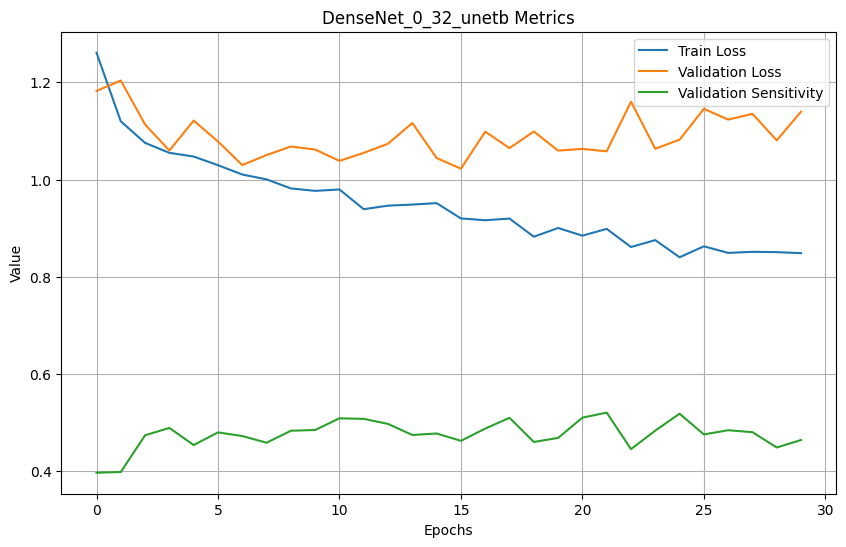

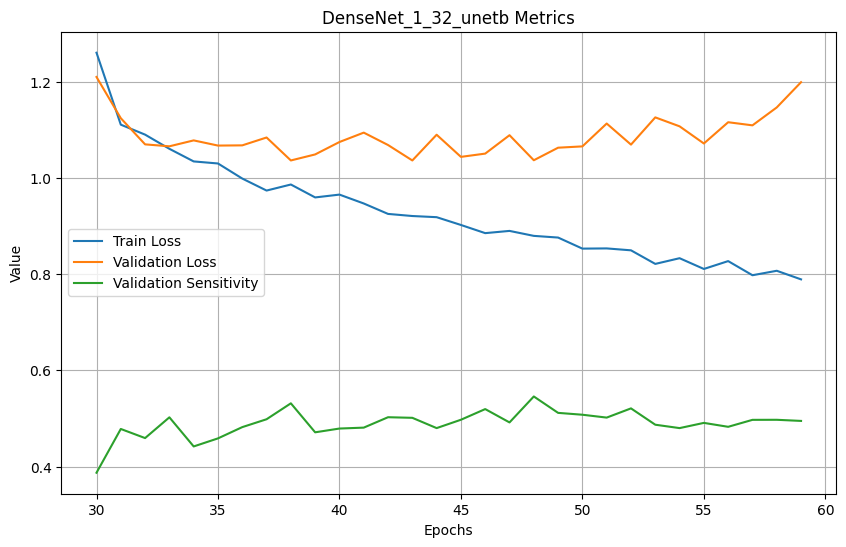

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/densenet_layer_unetb2.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


### unet multi

In [22]:
class_weights = calculate_dr_class_weights(unetm_train_dataset)

Class Weights: [ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [21]:
print(class_weights)

[ 0.39105099  4.75696203  0.56939394 10.15675676  2.64647887]


In [23]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("DenseNet", num_first_unfreeze, num_last_unfreeze, len(unetm_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with UNET Multiclass data------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         (224,224),
                         unetm_train_dataloader,
                         unetm_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_unetm")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/densenet_layer_unetm.csv")


-------------Training DenseNet with 0 Unfrozen First Layers and 2 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [00:32<00:00,  4.20it/s]


Epoch 1 completed, training loss: 1.48719994082068
Validation loss: 1.3974132776260375, Validation Accuracy: 41.25, Validation Sensitivty: 0.363178


100%|██████████| 137/137 [00:33<00:00,  4.15it/s]


Epoch 2 completed, training loss: 1.3446061880919185
Validation loss: 1.3150425553321838, Validation Accuracy: 50.98, Validation Sensitivty: 0.427766
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 3 completed, training loss: 1.2914164196835818
Validation loss: 1.2924974759419758, Validation Accuracy: 29.64, Validation Sensitivty: 0.380766


100%|██████████| 137/137 [00:33<00:00,  4.14it/s]


Epoch 4 completed, training loss: 1.2455210085332828
Validation loss: 1.2891377051671347, Validation Accuracy: 24.91, Validation Sensitivty: 0.379316


100%|██████████| 137/137 [00:33<00:00,  4.15it/s]


Epoch 5 completed, training loss: 1.2352120658777055
Validation loss: 1.2461157143115997, Validation Accuracy: 41.19, Validation Sensitivty: 0.428168
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 6 completed, training loss: 1.222291806318464
Validation loss: 1.231463885307312, Validation Accuracy: 32.52, Validation Sensitivty: 0.439369
Best model saved


100%|██████████| 137/137 [00:33<00:00,  4.14it/s]


Epoch 7 completed, training loss: 1.2063230250003565
Validation loss: 1.2615527192751566, Validation Accuracy: 32.57, Validation Sensitivty: 0.390132


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 8 completed, training loss: 1.1978922481954533
Validation loss: 1.2273622234662374, Validation Accuracy: 35.23, Validation Sensitivty: 0.427644


100%|██████████| 137/137 [00:33<00:00,  4.15it/s]


Epoch 9 completed, training loss: 1.2101103728705078
Validation loss: 1.281983099381129, Validation Accuracy: 34.33, Validation Sensitivty: 0.349014


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 10 completed, training loss: 1.2067109320285547
Validation loss: 1.2373955289522807, Validation Accuracy: 51.62, Validation Sensitivty: 0.392413


100%|██████████| 137/137 [00:30<00:00,  4.51it/s]


Epoch 11 completed, training loss: 1.1880942861529162
Validation loss: 1.1966149051984152, Validation Accuracy: 37.84, Validation Sensitivty: 0.426272


100%|██████████| 137/137 [00:29<00:00,  4.60it/s]


Epoch 12 completed, training loss: 1.171771229183587
Validation loss: 1.1979214151700337, Validation Accuracy: 45.08, Validation Sensitivty: 0.448423
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 13 completed, training loss: 1.180738067539939
Validation loss: 1.1994262993335725, Validation Accuracy: 47.74, Validation Sensitivty: 0.425648


100%|██████████| 137/137 [00:31<00:00,  4.36it/s]


Epoch 14 completed, training loss: 1.1514281726231541
Validation loss: 1.2419981439908345, Validation Accuracy: 36.14, Validation Sensitivty: 0.387307


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 15 completed, training loss: 1.1706318572489884
Validation loss: 1.2305612544218698, Validation Accuracy: 36.93, Validation Sensitivty: 0.411926


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 16 completed, training loss: 1.172411882094223
Validation loss: 1.1901579201221466, Validation Accuracy: 54.66, Validation Sensitivty: 0.444915


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 17 completed, training loss: 1.1591757740417536
Validation loss: 1.2468407909075419, Validation Accuracy: 36.08, Validation Sensitivty: 0.387915


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 18 completed, training loss: 1.1468397992370774
Validation loss: 1.2124265333016713, Validation Accuracy: 54.34, Validation Sensitivty: 0.440462


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 19 completed, training loss: 1.1405862226103345
Validation loss: 1.1908582746982574, Validation Accuracy: 51.68, Validation Sensitivty: 0.440918


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 20 completed, training loss: 1.1579604070552074
Validation loss: 1.2078318119049072, Validation Accuracy: 47.21, Validation Sensitivty: 0.433961


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 21 completed, training loss: 1.159773823118558
Validation loss: 1.220473345120748, Validation Accuracy: 51.41, Validation Sensitivty: 0.412147


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 22 completed, training loss: 1.1337410268122263
Validation loss: 1.211857755978902, Validation Accuracy: 46.99, Validation Sensitivty: 0.391676


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 23 completed, training loss: 1.1590709042375105
Validation loss: 1.1808278838793436, Validation Accuracy: 51.84, Validation Sensitivty: 0.477783
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 24 completed, training loss: 1.1726620697627101
Validation loss: 1.2217210670312246, Validation Accuracy: 37.57, Validation Sensitivty: 0.425088


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 25 completed, training loss: 1.1372569829878145
Validation loss: 1.2254914045333862, Validation Accuracy: 42.42, Validation Sensitivty: 0.407673


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 26 completed, training loss: 1.147387635533827
Validation loss: 1.182920382420222, Validation Accuracy: 40.61, Validation Sensitivty: 0.426700


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 27 completed, training loss: 1.1464352298827067
Validation loss: 1.2364269057909647, Validation Accuracy: 48.27, Validation Sensitivty: 0.449241


100%|██████████| 137/137 [00:31<00:00,  4.31it/s]


Epoch 28 completed, training loss: 1.1376191960634106
Validation loss: 1.178481117884318, Validation Accuracy: 39.22, Validation Sensitivty: 0.447430


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 29 completed, training loss: 1.1352173203099383
Validation loss: 1.188843208551407, Validation Accuracy: 52.74, Validation Sensitivty: 0.449643


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 30 completed, training loss: 1.1564807587296424
Validation loss: 1.1808710932731628, Validation Accuracy: 49.28, Validation Sensitivty: 0.423568
-------------Training DenseNet with 1 Unfrozen First Layers and 2 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [00:45<00:00,  3.01it/s]


Epoch 1 completed, training loss: 1.495878298787305
Validation loss: 1.3934379061063131, Validation Accuracy: 26.02, Validation Sensitivty: 0.352818


100%|██████████| 137/137 [00:45<00:00,  3.03it/s]


Epoch 2 completed, training loss: 1.3370340201106385
Validation loss: 1.3185439825057983, Validation Accuracy: 39.22, Validation Sensitivty: 0.384819
Best model saved


100%|██████████| 137/137 [00:45<00:00,  3.03it/s]


Epoch 3 completed, training loss: 1.285910091260924
Validation loss: 1.289070729414622, Validation Accuracy: 35.76, Validation Sensitivty: 0.374014


100%|██████████| 137/137 [00:45<00:00,  3.01it/s]


Epoch 4 completed, training loss: 1.239155768913074
Validation loss: 1.2576565504074098, Validation Accuracy: 25.49, Validation Sensitivty: 0.423074
Best model saved


100%|██████████| 137/137 [01:07<00:00,  2.04it/s]


Epoch 5 completed, training loss: 1.2269941337787322
Validation loss: 1.224048485358556, Validation Accuracy: 50.77, Validation Sensitivty: 0.444441
Best model saved


100%|██████████| 137/137 [02:09<00:00,  1.06it/s]


Epoch 6 completed, training loss: 1.2079789995277015
Validation loss: 1.2142033974329631, Validation Accuracy: 43.69, Validation Sensitivty: 0.436200


100%|██████████| 137/137 [01:46<00:00,  1.29it/s]


Epoch 7 completed, training loss: 1.1916481800322984
Validation loss: 1.218414024511973, Validation Accuracy: 40.18, Validation Sensitivty: 0.429124


100%|██████████| 137/137 [01:37<00:00,  1.41it/s]


Epoch 8 completed, training loss: 1.1808373749691203
Validation loss: 1.2172660171985625, Validation Accuracy: 40.50, Validation Sensitivty: 0.423825


100%|██████████| 137/137 [01:46<00:00,  1.29it/s]


Epoch 9 completed, training loss: 1.164403157512637
Validation loss: 1.2430532276630402, Validation Accuracy: 55.08, Validation Sensitivty: 0.395067


100%|██████████| 137/137 [01:36<00:00,  1.42it/s]


Epoch 10 completed, training loss: 1.162128195710426
Validation loss: 1.19261940519015, Validation Accuracy: 55.83, Validation Sensitivty: 0.414595


100%|██████████| 137/137 [01:35<00:00,  1.44it/s]


Epoch 11 completed, training loss: 1.1451516503835246
Validation loss: 1.202098367611567, Validation Accuracy: 48.27, Validation Sensitivty: 0.445356
Best model saved


100%|██████████| 137/137 [01:33<00:00,  1.46it/s]


Epoch 12 completed, training loss: 1.1362498124150464
Validation loss: 1.182826809088389, Validation Accuracy: 52.32, Validation Sensitivty: 0.433892


100%|██████████| 137/137 [01:32<00:00,  1.49it/s]


Epoch 13 completed, training loss: 1.1387595194969735
Validation loss: 1.1654599169890085, Validation Accuracy: 52.26, Validation Sensitivty: 0.473992
Best model saved


100%|██████████| 137/137 [01:31<00:00,  1.49it/s]


Epoch 14 completed, training loss: 1.1434407869394678
Validation loss: 1.1692372560501099, Validation Accuracy: 54.71, Validation Sensitivty: 0.459914


100%|██████████| 137/137 [01:26<00:00,  1.57it/s]


Epoch 15 completed, training loss: 1.1180426543646484
Validation loss: 1.153426984945933, Validation Accuracy: 47.63, Validation Sensitivty: 0.466582


100%|██████████| 137/137 [01:24<00:00,  1.63it/s]


Epoch 16 completed, training loss: 1.1357053822844567
Validation loss: 1.1671183904012044, Validation Accuracy: 58.97, Validation Sensitivty: 0.476831
Best model saved


100%|██████████| 137/137 [01:30<00:00,  1.52it/s]


Epoch 17 completed, training loss: 1.1278478903492002
Validation loss: 1.1912330508232116, Validation Accuracy: 52.00, Validation Sensitivty: 0.454641


100%|██████████| 137/137 [01:29<00:00,  1.52it/s]


Epoch 18 completed, training loss: 1.124372995247806
Validation loss: 1.1740790843963622, Validation Accuracy: 39.49, Validation Sensitivty: 0.440863


100%|██████████| 137/137 [01:36<00:00,  1.42it/s]


Epoch 19 completed, training loss: 1.11163206039554
Validation loss: 1.192446764310201, Validation Accuracy: 55.56, Validation Sensitivty: 0.424271


100%|██████████| 137/137 [02:10<00:00,  1.05it/s]


Epoch 20 completed, training loss: 1.1287803245286872
Validation loss: 1.1516259113947551, Validation Accuracy: 49.28, Validation Sensitivty: 0.471801


100%|██████████| 137/137 [01:33<00:00,  1.47it/s]


Epoch 21 completed, training loss: 1.106598666549599
Validation loss: 1.1852936546007793, Validation Accuracy: 47.74, Validation Sensitivty: 0.440361


100%|██████████| 137/137 [01:41<00:00,  1.35it/s]


Epoch 22 completed, training loss: 1.119612069025527
Validation loss: 1.1509281754493714, Validation Accuracy: 52.79, Validation Sensitivty: 0.499055
Best model saved


100%|██████████| 137/137 [01:29<00:00,  1.53it/s]


Epoch 23 completed, training loss: 1.113782803507617
Validation loss: 1.147029024362564, Validation Accuracy: 50.40, Validation Sensitivty: 0.466745


100%|██████████| 137/137 [01:33<00:00,  1.47it/s]


Epoch 24 completed, training loss: 1.1104760961811038
Validation loss: 1.1730950077374775, Validation Accuracy: 36.35, Validation Sensitivty: 0.438579


100%|██████████| 137/137 [01:29<00:00,  1.53it/s]


Epoch 25 completed, training loss: 1.1116456232801841
Validation loss: 1.2441680153210959, Validation Accuracy: 55.51, Validation Sensitivty: 0.381111


100%|██████████| 137/137 [01:28<00:00,  1.54it/s]


Epoch 26 completed, training loss: 1.103175646632257
Validation loss: 1.1458620746930441, Validation Accuracy: 39.33, Validation Sensitivty: 0.450489


100%|██████████| 137/137 [01:35<00:00,  1.43it/s]


Epoch 27 completed, training loss: 1.1064560565635235
Validation loss: 1.1444567024707795, Validation Accuracy: 53.54, Validation Sensitivty: 0.468154


100%|██████████| 137/137 [01:38<00:00,  1.39it/s]


Epoch 28 completed, training loss: 1.08430104186065
Validation loss: 1.1593860963980356, Validation Accuracy: 39.28, Validation Sensitivty: 0.439090


100%|██████████| 137/137 [01:33<00:00,  1.46it/s]


Epoch 29 completed, training loss: 1.0888277496734675
Validation loss: 1.1617831766605378, Validation Accuracy: 46.78, Validation Sensitivty: 0.457971


100%|██████████| 137/137 [01:38<00:00,  1.38it/s]


Epoch 30 completed, training loss: 1.083850086605462
Validation loss: 1.1920162538687389, Validation Accuracy: 53.06, Validation Sensitivty: 0.434753
-------------Training DenseNet with 0 Unfrozen First Layers and 8 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [01:03<00:00,  2.17it/s]


Epoch 1 completed, training loss: 1.390514164945505
Validation loss: 1.2535092075665792, Validation Accuracy: 56.84, Validation Sensitivty: 0.407247


100%|██████████| 137/137 [01:01<00:00,  2.24it/s]


Epoch 2 completed, training loss: 1.20760594232239
Validation loss: 1.233230714003245, Validation Accuracy: 58.81, Validation Sensitivty: 0.425169
Best model saved


100%|██████████| 137/137 [01:01<00:00,  2.23it/s]


Epoch 3 completed, training loss: 1.1510682079913843
Validation loss: 1.161498667796453, Validation Accuracy: 48.38, Validation Sensitivty: 0.457456
Best model saved


100%|██████████| 137/137 [00:58<00:00,  2.35it/s]


Epoch 4 completed, training loss: 1.139762584745449
Validation loss: 1.1829439957936605, Validation Accuracy: 49.07, Validation Sensitivty: 0.417442


100%|██████████| 137/137 [01:04<00:00,  2.11it/s]


Epoch 5 completed, training loss: 1.1064865036602438
Validation loss: 1.1855373322963714, Validation Accuracy: 56.52, Validation Sensitivty: 0.409211


100%|██████████| 137/137 [01:01<00:00,  2.24it/s]


Epoch 6 completed, training loss: 1.089533651397176
Validation loss: 1.1503021876017252, Validation Accuracy: 60.88, Validation Sensitivty: 0.476888
Best model saved


100%|██████████| 137/137 [01:00<00:00,  2.27it/s]


Epoch 7 completed, training loss: 1.0795325684721453
Validation loss: 1.1496220489343008, Validation Accuracy: 48.22, Validation Sensitivty: 0.451707


100%|██████████| 137/137 [01:01<00:00,  2.21it/s]


Epoch 8 completed, training loss: 1.0643191163557288
Validation loss: 1.0940907776355744, Validation Accuracy: 52.00, Validation Sensitivty: 0.462114


100%|██████████| 137/137 [01:01<00:00,  2.23it/s]


Epoch 9 completed, training loss: 1.0565840797702761
Validation loss: 1.1285179456075032, Validation Accuracy: 55.14, Validation Sensitivty: 0.467297


100%|██████████| 137/137 [01:01<00:00,  2.24it/s]


Epoch 10 completed, training loss: 1.0425407316562902
Validation loss: 1.1174740175406137, Validation Accuracy: 57.69, Validation Sensitivty: 0.492710
Best model saved


100%|██████████| 137/137 [01:00<00:00,  2.27it/s]


Epoch 11 completed, training loss: 1.027838916239077
Validation loss: 1.1335305154323578, Validation Accuracy: 56.84, Validation Sensitivty: 0.427363


100%|██████████| 137/137 [01:02<00:00,  2.21it/s]


Epoch 12 completed, training loss: 1.0238587412520916
Validation loss: 1.139052794377009, Validation Accuracy: 62.96, Validation Sensitivty: 0.459021


100%|██████████| 137/137 [01:01<00:00,  2.23it/s]


Epoch 13 completed, training loss: 1.0190464493131985
Validation loss: 1.1405291219552358, Validation Accuracy: 57.10, Validation Sensitivty: 0.451931


100%|██████████| 137/137 [01:00<00:00,  2.25it/s]


Epoch 14 completed, training loss: 1.0216806870307364
Validation loss: 1.1297165791193644, Validation Accuracy: 48.75, Validation Sensitivty: 0.450455


100%|██████████| 137/137 [01:02<00:00,  2.19it/s]


Epoch 15 completed, training loss: 1.0006499251309973
Validation loss: 1.0897835771242776, Validation Accuracy: 55.72, Validation Sensitivty: 0.454337


100%|██████████| 137/137 [01:03<00:00,  2.17it/s]


Epoch 16 completed, training loss: 0.9977688045397292
Validation loss: 1.1160418828328451, Validation Accuracy: 58.33, Validation Sensitivty: 0.473851


100%|██████████| 137/137 [01:00<00:00,  2.26it/s]


Epoch 17 completed, training loss: 1.0082928399099922
Validation loss: 1.166187689701716, Validation Accuracy: 64.29, Validation Sensitivty: 0.447669


100%|██████████| 137/137 [01:02<00:00,  2.21it/s]


Epoch 18 completed, training loss: 0.9777195070781847
Validation loss: 1.1273745318253836, Validation Accuracy: 61.10, Validation Sensitivty: 0.469346


100%|██████████| 137/137 [01:00<00:00,  2.28it/s]


Epoch 19 completed, training loss: 0.9885037611000729
Validation loss: 1.1012491186459858, Validation Accuracy: 59.39, Validation Sensitivty: 0.484047


100%|██████████| 137/137 [01:00<00:00,  2.28it/s]


Epoch 20 completed, training loss: 0.9671779723063002
Validation loss: 1.12971071600914, Validation Accuracy: 58.38, Validation Sensitivty: 0.424615


100%|██████████| 137/137 [01:00<00:00,  2.26it/s]


Epoch 21 completed, training loss: 0.9652012804128828
Validation loss: 1.1268824736277263, Validation Accuracy: 54.98, Validation Sensitivty: 0.454799


100%|██████████| 137/137 [01:02<00:00,  2.19it/s]


Epoch 22 completed, training loss: 0.9692944527542504
Validation loss: 1.1083792606989542, Validation Accuracy: 58.12, Validation Sensitivty: 0.457281


100%|██████████| 137/137 [01:01<00:00,  2.25it/s]


Epoch 23 completed, training loss: 0.9603203239232084
Validation loss: 1.127717407544454, Validation Accuracy: 51.68, Validation Sensitivty: 0.436447


100%|██████████| 137/137 [01:01<00:00,  2.23it/s]


Epoch 24 completed, training loss: 0.9580669690222636
Validation loss: 1.119565765062968, Validation Accuracy: 53.59, Validation Sensitivty: 0.491178


100%|██████████| 137/137 [01:02<00:00,  2.21it/s]


Epoch 25 completed, training loss: 0.9716503293844905
Validation loss: 1.1390214641888936, Validation Accuracy: 52.58, Validation Sensitivty: 0.479793


100%|██████████| 137/137 [01:01<00:00,  2.23it/s]


Epoch 26 completed, training loss: 0.946711353141896
Validation loss: 1.1292977015177408, Validation Accuracy: 47.63, Validation Sensitivty: 0.448097


100%|██████████| 137/137 [01:00<00:00,  2.27it/s]


Epoch 27 completed, training loss: 0.9304162846864575
Validation loss: 1.1305320858955383, Validation Accuracy: 56.25, Validation Sensitivty: 0.476690


100%|██████████| 137/137 [00:59<00:00,  2.30it/s]


Epoch 28 completed, training loss: 0.9370390498725167
Validation loss: 1.1069928566614786, Validation Accuracy: 50.51, Validation Sensitivty: 0.459689


100%|██████████| 137/137 [01:02<00:00,  2.20it/s]


Epoch 29 completed, training loss: 0.9402783047543825
Validation loss: 1.1560495018959045, Validation Accuracy: 50.45, Validation Sensitivty: 0.486299


100%|██████████| 137/137 [01:01<00:00,  2.22it/s]


Epoch 30 completed, training loss: 0.9264731985809159
Validation loss: 1.128598270813624, Validation Accuracy: 48.64, Validation Sensitivty: 0.475931
-------------Training DenseNet with 1 Unfrozen First Layers and 8 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [02:48<00:00,  1.23s/it]


Epoch 1 completed, training loss: 1.3736130616960733
Validation loss: 1.2433651248613993, Validation Accuracy: 29.64, Validation Sensitivty: 0.360314


100%|██████████| 137/137 [02:33<00:00,  1.12s/it]


Epoch 2 completed, training loss: 1.209447576181732
Validation loss: 1.1879501382509867, Validation Accuracy: 55.24, Validation Sensitivty: 0.434453
Best model saved


100%|██████████| 137/137 [02:39<00:00,  1.16s/it]


Epoch 3 completed, training loss: 1.1586142839306461
Validation loss: 1.1691863934199016, Validation Accuracy: 57.96, Validation Sensitivty: 0.401718


100%|██████████| 137/137 [02:33<00:00,  1.12s/it]


Epoch 4 completed, training loss: 1.127657830280109
Validation loss: 1.1580629070599875, Validation Accuracy: 55.67, Validation Sensitivty: 0.382317


100%|██████████| 137/137 [02:55<00:00,  1.28s/it]


Epoch 5 completed, training loss: 1.077787918330979
Validation loss: 1.0941536486148835, Validation Accuracy: 52.26, Validation Sensitivty: 0.492289
Best model saved


100%|██████████| 137/137 [01:43<00:00,  1.32it/s]


Epoch 6 completed, training loss: 1.0806618624360023
Validation loss: 1.170433078209559, Validation Accuracy: 60.30, Validation Sensitivty: 0.463005


100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 7 completed, training loss: 1.0629418675046767
Validation loss: 1.1240236620108286, Validation Accuracy: 56.31, Validation Sensitivty: 0.452972


100%|██████████| 137/137 [00:38<00:00,  3.60it/s]


Epoch 8 completed, training loss: 1.075330068595218
Validation loss: 1.105302349726359, Validation Accuracy: 55.35, Validation Sensitivty: 0.470081


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 9 completed, training loss: 1.0576507549216276
Validation loss: 1.1305153449376424, Validation Accuracy: 61.63, Validation Sensitivty: 0.457210


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 10 completed, training loss: 1.0493105906639657
Validation loss: 1.0811086455980936, Validation Accuracy: 60.46, Validation Sensitivty: 0.468146


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 11 completed, training loss: 1.046963523339181
Validation loss: 1.1533161640167235, Validation Accuracy: 58.49, Validation Sensitivty: 0.451800


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 12 completed, training loss: 1.023160568554036
Validation loss: 1.1095239281654359, Validation Accuracy: 53.65, Validation Sensitivty: 0.481265


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 13 completed, training loss: 1.0290200214316374
Validation loss: 1.0778361678123474, Validation Accuracy: 60.56, Validation Sensitivty: 0.527667
Best model saved


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 14 completed, training loss: 1.011768649094296
Validation loss: 1.1249705970287323, Validation Accuracy: 63.23, Validation Sensitivty: 0.454721


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch 15 completed, training loss: 1.0165140341668233
Validation loss: 1.067918179432551, Validation Accuracy: 53.59, Validation Sensitivty: 0.486199


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch 16 completed, training loss: 0.9873422606147989
Validation loss: 1.0998679478963216, Validation Accuracy: 50.45, Validation Sensitivty: 0.498413


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 17 completed, training loss: 0.9990168705473851
Validation loss: 1.127910449107488, Validation Accuracy: 59.77, Validation Sensitivty: 0.504554


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 18 completed, training loss: 0.980660890575743
Validation loss: 1.1843167165915172, Validation Accuracy: 61.68, Validation Sensitivty: 0.472748


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 19 completed, training loss: 0.9703691375516627
Validation loss: 1.1643555303414663, Validation Accuracy: 61.58, Validation Sensitivty: 0.482488


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 20 completed, training loss: 0.9630760098025747
Validation loss: 1.1370272179444632, Validation Accuracy: 60.94, Validation Sensitivty: 0.519464


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch 21 completed, training loss: 0.9714616023711045
Validation loss: 1.0854633112748464, Validation Accuracy: 59.50, Validation Sensitivty: 0.463796


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch 22 completed, training loss: 0.9712123566300329
Validation loss: 1.1538916607697804, Validation Accuracy: 53.75, Validation Sensitivty: 0.474268


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch 23 completed, training loss: 0.9616803057002326
Validation loss: 1.1324655652046203, Validation Accuracy: 61.73, Validation Sensitivty: 0.495250


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch 24 completed, training loss: 0.9256005056583099
Validation loss: 1.0847812871138254, Validation Accuracy: 53.86, Validation Sensitivty: 0.501376


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch 25 completed, training loss: 0.950964490427588
Validation loss: 1.1232332130273184, Validation Accuracy: 52.90, Validation Sensitivty: 0.445068


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 26 completed, training loss: 0.9486545842059337
Validation loss: 1.0813922087351482, Validation Accuracy: 47.84, Validation Sensitivty: 0.476960


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 27 completed, training loss: 0.9338277117179258
Validation loss: 1.0794909318288168, Validation Accuracy: 58.86, Validation Sensitivty: 0.496261


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 28 completed, training loss: 0.9224741563309719
Validation loss: 1.1175570527712504, Validation Accuracy: 57.32, Validation Sensitivty: 0.451583


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 29 completed, training loss: 0.9092802583736225
Validation loss: 1.1048445065816244, Validation Accuracy: 56.41, Validation Sensitivty: 0.512347


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 30 completed, training loss: 0.9105221951094857
Validation loss: 1.081861686706543, Validation Accuracy: 57.16, Validation Sensitivty: 0.493800
-------------Training DenseNet with 0 Unfrozen First Layers and 16 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 1 completed, training loss: 1.3485134722542589
Validation loss: 1.2197527925173441, Validation Accuracy: 51.57, Validation Sensitivty: 0.404524


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 2 completed, training loss: 1.164505463447014
Validation loss: 1.1943886935710908, Validation Accuracy: 51.68, Validation Sensitivty: 0.410860
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 3 completed, training loss: 1.1411727236135163
Validation loss: 1.1272436837355295, Validation Accuracy: 56.20, Validation Sensitivty: 0.438063
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 4 completed, training loss: 1.0966028505868286
Validation loss: 1.1613378802935281, Validation Accuracy: 50.93, Validation Sensitivty: 0.478021
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 5 completed, training loss: 1.083848372863157
Validation loss: 1.1125423073768617, Validation Accuracy: 57.96, Validation Sensitivty: 0.471601


100%|██████████| 137/137 [00:33<00:00,  4.14it/s]


Epoch 6 completed, training loss: 1.0645358858317355
Validation loss: 1.1135919610659282, Validation Accuracy: 45.29, Validation Sensitivty: 0.427075


100%|██████████| 137/137 [00:32<00:00,  4.15it/s]


Epoch 7 completed, training loss: 1.067515989724737
Validation loss: 1.208071333169937, Validation Accuracy: 49.07, Validation Sensitivty: 0.409119


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 8 completed, training loss: 1.0472436595137102
Validation loss: 1.114554258187612, Validation Accuracy: 53.33, Validation Sensitivty: 0.459829


100%|██████████| 137/137 [00:33<00:00,  4.15it/s]


Epoch 9 completed, training loss: 1.0210887750569921
Validation loss: 1.1571602463722228, Validation Accuracy: 59.02, Validation Sensitivty: 0.477109


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 10 completed, training loss: 1.027886881445446
Validation loss: 1.1320434192816415, Validation Accuracy: 52.58, Validation Sensitivty: 0.453655


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 11 completed, training loss: 1.008058551454196
Validation loss: 1.1210135479768117, Validation Accuracy: 58.54, Validation Sensitivty: 0.440508


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 12 completed, training loss: 1.0004329972893653
Validation loss: 1.1023568938175836, Validation Accuracy: 59.07, Validation Sensitivty: 0.444910


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 13 completed, training loss: 0.9839427945387624
Validation loss: 1.1228297193845114, Validation Accuracy: 51.30, Validation Sensitivty: 0.448986


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 14 completed, training loss: 0.9808968531824377
Validation loss: 1.062693750858307, Validation Accuracy: 48.59, Validation Sensitivty: 0.451358


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 15 completed, training loss: 0.980406299124669
Validation loss: 1.1161909500757854, Validation Accuracy: 57.90, Validation Sensitivty: 0.453207


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 16 completed, training loss: 0.962653678264061
Validation loss: 1.1386198818683624, Validation Accuracy: 57.58, Validation Sensitivty: 0.430856


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 17 completed, training loss: 0.9523323648167352
Validation loss: 1.1462491810321809, Validation Accuracy: 57.80, Validation Sensitivty: 0.471453


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 18 completed, training loss: 0.9527966849995355
Validation loss: 1.1112606445948283, Validation Accuracy: 57.37, Validation Sensitivty: 0.453798


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 19 completed, training loss: 0.9578841132839231
Validation loss: 1.1262926042079926, Validation Accuracy: 53.49, Validation Sensitivty: 0.483573
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 20 completed, training loss: 0.9384845129764863
Validation loss: 1.099643882115682, Validation Accuracy: 47.47, Validation Sensitivty: 0.468036


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 21 completed, training loss: 0.9240577247020972
Validation loss: 1.1399883886178335, Validation Accuracy: 52.05, Validation Sensitivty: 0.458228


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 22 completed, training loss: 0.9332770753080828
Validation loss: 1.1295063932736715, Validation Accuracy: 58.70, Validation Sensitivty: 0.485260
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 23 completed, training loss: 0.9409584938174617
Validation loss: 1.1183984418710073, Validation Accuracy: 57.58, Validation Sensitivty: 0.463329


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Epoch 24 completed, training loss: 0.9352302916728668
Validation loss: 1.1025806486606597, Validation Accuracy: 49.23, Validation Sensitivty: 0.509166
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 25 completed, training loss: 0.9107920231610319
Validation loss: 1.1252406895160676, Validation Accuracy: 50.51, Validation Sensitivty: 0.459616


100%|██████████| 137/137 [00:32<00:00,  4.19it/s]


Epoch 26 completed, training loss: 0.9107420340071629
Validation loss: 1.1191967487335206, Validation Accuracy: 50.82, Validation Sensitivty: 0.533265
Best model saved


100%|██████████| 137/137 [00:33<00:00,  4.14it/s]


Epoch 27 completed, training loss: 0.9022586415283871
Validation loss: 1.118887867530187, Validation Accuracy: 54.87, Validation Sensitivty: 0.482634


100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


Epoch 28 completed, training loss: 0.8852021417913646
Validation loss: 1.192520002524058, Validation Accuracy: 60.30, Validation Sensitivty: 0.441991


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 29 completed, training loss: 0.8967372835987676
Validation loss: 1.1810779730478922, Validation Accuracy: 56.09, Validation Sensitivty: 0.478770


100%|██████████| 137/137 [00:32<00:00,  4.17it/s]


Epoch 30 completed, training loss: 0.9043772242365092
Validation loss: 1.141915625333786, Validation Accuracy: 55.14, Validation Sensitivty: 0.457803
-------------Training DenseNet with 1 Unfrozen First Layers and 16 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 1 completed, training loss: 1.3330004563296798
Validation loss: 1.2229233622550963, Validation Accuracy: 24.11, Validation Sensitivty: 0.427361


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 2 completed, training loss: 1.1768772828317906
Validation loss: 1.1698079645633697, Validation Accuracy: 54.39, Validation Sensitivty: 0.444282
Best model saved


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 3 completed, training loss: 1.1187940409583768
Validation loss: 1.1264627615610758, Validation Accuracy: 39.86, Validation Sensitivty: 0.451353
Best model saved


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 4 completed, training loss: 1.0921677324893702
Validation loss: 1.1152029077212016, Validation Accuracy: 51.20, Validation Sensitivty: 0.426591


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 5 completed, training loss: 1.0783237162297659
Validation loss: 1.1245124499003092, Validation Accuracy: 56.84, Validation Sensitivty: 0.459205
Best model saved


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 6 completed, training loss: 1.056552618524454
Validation loss: 1.1116689840952556, Validation Accuracy: 54.34, Validation Sensitivty: 0.489431
Best model saved


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 7 completed, training loss: 1.0363283544561288
Validation loss: 1.131783769528071, Validation Accuracy: 55.03, Validation Sensitivty: 0.464932


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 8 completed, training loss: 1.0239841420285023
Validation loss: 1.1189543763796488, Validation Accuracy: 56.84, Validation Sensitivty: 0.470649


100%|██████████| 137/137 [00:37<00:00,  3.67it/s]


Epoch 9 completed, training loss: 1.025685229440675
Validation loss: 1.1089650988578796, Validation Accuracy: 55.30, Validation Sensitivty: 0.455558


100%|██████████| 137/137 [00:34<00:00,  3.93it/s]


Epoch 10 completed, training loss: 1.004426834357046
Validation loss: 1.0943527519702911, Validation Accuracy: 55.56, Validation Sensitivty: 0.485007


100%|██████████| 137/137 [00:35<00:00,  3.89it/s]


Epoch 11 completed, training loss: 0.9978194332470859
Validation loss: 1.1742941419283548, Validation Accuracy: 49.87, Validation Sensitivty: 0.474265


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 12 completed, training loss: 0.9851451872909156
Validation loss: 1.0783707916736602, Validation Accuracy: 53.11, Validation Sensitivty: 0.485007


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 13 completed, training loss: 0.9721690007369884
Validation loss: 1.113498898347219, Validation Accuracy: 48.38, Validation Sensitivty: 0.477210


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 14 completed, training loss: 0.946552548530328
Validation loss: 1.119177556037903, Validation Accuracy: 49.65, Validation Sensitivty: 0.467041


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 15 completed, training loss: 0.9487795042295526
Validation loss: 1.0929763515790303, Validation Accuracy: 41.03, Validation Sensitivty: 0.479434


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 16 completed, training loss: 0.9412542350970916
Validation loss: 1.1031286438306174, Validation Accuracy: 54.98, Validation Sensitivty: 0.461890


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch 17 completed, training loss: 0.932092425596975
Validation loss: 1.0984809935092925, Validation Accuracy: 53.22, Validation Sensitivty: 0.469653


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch 18 completed, training loss: 0.9348664196738361
Validation loss: 1.1015439331531525, Validation Accuracy: 47.31, Validation Sensitivty: 0.455434


100%|██████████| 137/137 [00:37<00:00,  3.63it/s]


Epoch 19 completed, training loss: 0.9232308251144242
Validation loss: 1.0787888924280802, Validation Accuracy: 56.25, Validation Sensitivty: 0.512582
Best model saved


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 20 completed, training loss: 0.9252087478220028
Validation loss: 1.0981524527072906, Validation Accuracy: 56.57, Validation Sensitivty: 0.449161


100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch 21 completed, training loss: 0.9007851481437683
Validation loss: 1.074495828151703, Validation Accuracy: 51.89, Validation Sensitivty: 0.512036


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 22 completed, training loss: 0.9150260108230758
Validation loss: 1.0880863825480143, Validation Accuracy: 51.57, Validation Sensitivty: 0.496158


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 23 completed, training loss: 0.8827744202457205
Validation loss: 1.0921974817911784, Validation Accuracy: 53.43, Validation Sensitivty: 0.462042


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 24 completed, training loss: 0.8711816968709013
Validation loss: 1.1240342438220978, Validation Accuracy: 55.99, Validation Sensitivty: 0.474436


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch 25 completed, training loss: 0.8740402346979963
Validation loss: 1.1107532242933909, Validation Accuracy: 54.76, Validation Sensitivty: 0.467977


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch 26 completed, training loss: 0.8784532501314678
Validation loss: 1.0975981632868448, Validation Accuracy: 56.41, Validation Sensitivty: 0.485865


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch 27 completed, training loss: 0.8709351927259542
Validation loss: 1.1511182725429534, Validation Accuracy: 60.46, Validation Sensitivty: 0.506648


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch 28 completed, training loss: 0.8635260199543333
Validation loss: 1.1415391902128855, Validation Accuracy: 60.03, Validation Sensitivty: 0.515919
Best model saved


100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch 29 completed, training loss: 0.8479957149846711
Validation loss: 1.1097998897234598, Validation Accuracy: 59.50, Validation Sensitivty: 0.492955


100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch 30 completed, training loss: 0.8416347475382533
Validation loss: 1.1118777652581533, Validation Accuracy: 55.30, Validation Sensitivty: 0.491970
-------------Training DenseNet with 0 Unfrozen First Layers and 32 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [00:37<00:00,  3.63it/s]


Epoch 1 completed, training loss: 1.3026160441175865
Validation loss: 1.1665334820747375, Validation Accuracy: 55.46, Validation Sensitivty: 0.417350


100%|██████████| 137/137 [00:31<00:00,  4.42it/s]


Epoch 2 completed, training loss: 1.1426348573099958
Validation loss: 1.1443569779396057, Validation Accuracy: 55.51, Validation Sensitivty: 0.436082
Best model saved


100%|██████████| 137/137 [00:33<00:00,  4.13it/s]


Epoch 3 completed, training loss: 1.1076144945882533
Validation loss: 1.1288903832435608, Validation Accuracy: 48.96, Validation Sensitivty: 0.474650
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 4 completed, training loss: 1.0888680859203757
Validation loss: 1.131555426120758, Validation Accuracy: 46.99, Validation Sensitivty: 0.467763


100%|██████████| 137/137 [00:31<00:00,  4.41it/s]


Epoch 5 completed, training loss: 1.053085823998834
Validation loss: 1.0892453690369923, Validation Accuracy: 51.68, Validation Sensitivty: 0.485609
Best model saved


100%|██████████| 137/137 [00:30<00:00,  4.52it/s]


Epoch 6 completed, training loss: 1.0357664806129288
Validation loss: 1.1329054276148478, Validation Accuracy: 49.97, Validation Sensitivty: 0.497451
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 7 completed, training loss: 1.0194464817534399
Validation loss: 1.2268250048160554, Validation Accuracy: 63.28, Validation Sensitivty: 0.443434


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 8 completed, training loss: 1.0262647062322519
Validation loss: 1.1190905054410298, Validation Accuracy: 58.59, Validation Sensitivty: 0.467270


100%|██████████| 137/137 [00:31<00:00,  4.41it/s]


Epoch 9 completed, training loss: 1.0089887067349288
Validation loss: 1.1023303230603536, Validation Accuracy: 56.73, Validation Sensitivty: 0.479213


100%|██████████| 137/137 [00:30<00:00,  4.47it/s]


Epoch 10 completed, training loss: 0.9675362327673139
Validation loss: 1.1655488948027293, Validation Accuracy: 65.99, Validation Sensitivty: 0.444426


100%|██████████| 137/137 [00:37<00:00,  3.69it/s]


Epoch 11 completed, training loss: 0.9759187367710754
Validation loss: 1.1420689006646474, Validation Accuracy: 58.75, Validation Sensitivty: 0.444123


100%|██████████| 137/137 [00:30<00:00,  4.42it/s]


Epoch 12 completed, training loss: 0.9963166209032935
Validation loss: 1.1088149845600128, Validation Accuracy: 56.31, Validation Sensitivty: 0.454308


100%|██████████| 137/137 [00:31<00:00,  4.39it/s]


Epoch 13 completed, training loss: 0.9889812669614806
Validation loss: 1.088124789794286, Validation Accuracy: 56.04, Validation Sensitivty: 0.505714
Best model saved


100%|██████████| 137/137 [00:30<00:00,  4.44it/s]


Epoch 14 completed, training loss: 0.9379326479278342
Validation loss: 1.151517007748286, Validation Accuracy: 59.29, Validation Sensitivty: 0.443874


100%|██████████| 137/137 [00:30<00:00,  4.50it/s]


Epoch 15 completed, training loss: 0.945377827995885
Validation loss: 1.1068188587824503, Validation Accuracy: 58.12, Validation Sensitivty: 0.474741


100%|██████████| 137/137 [00:30<00:00,  4.51it/s]


Epoch 16 completed, training loss: 0.9574218461983395
Validation loss: 1.1634602785110473, Validation Accuracy: 61.79, Validation Sensitivty: 0.482141


100%|██████████| 137/137 [00:30<00:00,  4.54it/s]


Epoch 17 completed, training loss: 0.9438342813157687
Validation loss: 1.1407503187656403, Validation Accuracy: 53.49, Validation Sensitivty: 0.477861


100%|██████████| 137/137 [00:30<00:00,  4.52it/s]


Epoch 18 completed, training loss: 0.9493316150929806
Validation loss: 1.1018448352813721, Validation Accuracy: 57.90, Validation Sensitivty: 0.506429
Best model saved


100%|██████████| 137/137 [00:30<00:00,  4.51it/s]


Epoch 19 completed, training loss: 0.9223175327273181
Validation loss: 1.0871677418549857, Validation Accuracy: 54.02, Validation Sensitivty: 0.510695
Best model saved


100%|██████████| 137/137 [00:30<00:00,  4.48it/s]


Epoch 20 completed, training loss: 0.9228784233114146
Validation loss: 1.1604003012180328, Validation Accuracy: 57.80, Validation Sensitivty: 0.472659


100%|██████████| 137/137 [00:30<00:00,  4.47it/s]


Epoch 21 completed, training loss: 0.9112628450358871
Validation loss: 1.1465481261412303, Validation Accuracy: 59.50, Validation Sensitivty: 0.462952


100%|██████████| 137/137 [00:30<00:00,  4.54it/s]


Epoch 22 completed, training loss: 0.9141479761061007
Validation loss: 1.2353163580099742, Validation Accuracy: 56.89, Validation Sensitivty: 0.461438


100%|██████████| 137/137 [00:30<00:00,  4.49it/s]


Epoch 23 completed, training loss: 0.8988443693540392
Validation loss: 1.1100750744342804, Validation Accuracy: 56.36, Validation Sensitivty: 0.506209


100%|██████████| 137/137 [00:30<00:00,  4.45it/s]


Epoch 24 completed, training loss: 0.8764927182754461
Validation loss: 1.2082076251506806, Validation Accuracy: 55.61, Validation Sensitivty: 0.495274


100%|██████████| 137/137 [00:30<00:00,  4.47it/s]


Epoch 25 completed, training loss: 0.8953442443026244
Validation loss: 1.1294305781523386, Validation Accuracy: 49.97, Validation Sensitivty: 0.492173


100%|██████████| 137/137 [00:30<00:00,  4.51it/s]


Epoch 26 completed, training loss: 0.8828246954583774
Validation loss: 1.2233334978421528, Validation Accuracy: 56.41, Validation Sensitivty: 0.480686


100%|██████████| 137/137 [00:31<00:00,  4.41it/s]


Epoch 27 completed, training loss: 0.9004402861107875
Validation loss: 1.228626968463262, Validation Accuracy: 50.40, Validation Sensitivty: 0.457101


100%|██████████| 137/137 [00:30<00:00,  4.52it/s]


Epoch 28 completed, training loss: 0.8518461624201197
Validation loss: 1.0839962283770244, Validation Accuracy: 41.99, Validation Sensitivty: 0.465066


100%|██████████| 137/137 [00:30<00:00,  4.46it/s]


Epoch 29 completed, training loss: 0.8665773542257991
Validation loss: 1.160767279068629, Validation Accuracy: 52.69, Validation Sensitivty: 0.472806


100%|██████████| 137/137 [00:30<00:00,  4.47it/s]


Epoch 30 completed, training loss: 0.8603087963849089
Validation loss: 1.1720823605855306, Validation Accuracy: 54.66, Validation Sensitivty: 0.470259
-------------Training DenseNet with 1 Unfrozen First Layers and 32 Unfrozen Last Layers with clahe data------------


100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


Epoch 1 completed, training loss: 1.2879058518548951
Validation loss: 1.1804894904295604, Validation Accuracy: 56.15, Validation Sensitivty: 0.427373


100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


Epoch 2 completed, training loss: 1.1240585759608415
Validation loss: 1.1482185224692028, Validation Accuracy: 55.19, Validation Sensitivty: 0.419723


100%|██████████| 137/137 [00:39<00:00,  3.49it/s]


Epoch 3 completed, training loss: 1.1098641339879836
Validation loss: 1.161007136106491, Validation Accuracy: 50.35, Validation Sensitivty: 0.460195
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.43it/s]


Epoch 4 completed, training loss: 1.076339730816166
Validation loss: 1.1407021641731263, Validation Accuracy: 50.40, Validation Sensitivty: 0.468578
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.43it/s]


Epoch 5 completed, training loss: 1.0343461589221536
Validation loss: 1.1239204068978628, Validation Accuracy: 60.40, Validation Sensitivty: 0.470366
Best model saved


100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 6 completed, training loss: 1.0426247698547195
Validation loss: 1.1013670444488526, Validation Accuracy: 53.43, Validation Sensitivty: 0.454773


100%|██████████| 137/137 [00:39<00:00,  3.43it/s]


Epoch 7 completed, training loss: 1.0186549425125122
Validation loss: 1.1143813908100129, Validation Accuracy: 49.12, Validation Sensitivty: 0.451942


100%|██████████| 137/137 [00:40<00:00,  3.34it/s]


Epoch 8 completed, training loss: 1.0000362444097979
Validation loss: 1.0914918959140778, Validation Accuracy: 51.46, Validation Sensitivty: 0.479642
Best model saved


100%|██████████| 137/137 [00:40<00:00,  3.40it/s]


Epoch 9 completed, training loss: 0.9712647517232129
Validation loss: 1.088624229033788, Validation Accuracy: 52.26, Validation Sensitivty: 0.519599
Best model saved


100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 10 completed, training loss: 0.9951474805817987
Validation loss: 1.099562523762385, Validation Accuracy: 52.95, Validation Sensitivty: 0.460769


100%|██████████| 137/137 [00:40<00:00,  3.40it/s]


Epoch 11 completed, training loss: 0.9728226235313137
Validation loss: 1.1022422432899475, Validation Accuracy: 57.21, Validation Sensitivty: 0.453475


100%|██████████| 137/137 [00:45<00:00,  3.04it/s]


Epoch 12 completed, training loss: 0.9631153588747456
Validation loss: 1.1086303015549979, Validation Accuracy: 59.50, Validation Sensitivty: 0.498236


100%|██████████| 137/137 [00:39<00:00,  3.49it/s]


Epoch 13 completed, training loss: 0.9362333843307774
Validation loss: 1.054831967751185, Validation Accuracy: 50.98, Validation Sensitivty: 0.467284


100%|██████████| 137/137 [00:39<00:00,  3.44it/s]


Epoch 14 completed, training loss: 0.9276480535521124
Validation loss: 1.0784218430519104, Validation Accuracy: 48.70, Validation Sensitivty: 0.486756


100%|██████████| 137/137 [00:40<00:00,  3.39it/s]


Epoch 15 completed, training loss: 0.9183555284555811
Validation loss: 1.0803272028764088, Validation Accuracy: 53.06, Validation Sensitivty: 0.474245


100%|██████████| 137/137 [00:40<00:00,  3.41it/s]


Epoch 16 completed, training loss: 0.9166873819636603
Validation loss: 1.1004588941733042, Validation Accuracy: 54.50, Validation Sensitivty: 0.452268


100%|██████████| 137/137 [00:39<00:00,  3.43it/s]


Epoch 17 completed, training loss: 0.8940232687622961
Validation loss: 1.0679941078027089, Validation Accuracy: 50.56, Validation Sensitivty: 0.501273


100%|██████████| 137/137 [00:41<00:00,  3.33it/s]


Epoch 18 completed, training loss: 0.8685703643047027
Validation loss: 1.1535172939300538, Validation Accuracy: 63.76, Validation Sensitivty: 0.461663


100%|██████████| 137/137 [00:40<00:00,  3.40it/s]


Epoch 19 completed, training loss: 0.8849949819328141
Validation loss: 1.1201994836330413, Validation Accuracy: 58.91, Validation Sensitivty: 0.474718


100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 20 completed, training loss: 0.8809948450457441
Validation loss: 1.0711401561896006, Validation Accuracy: 57.48, Validation Sensitivty: 0.519951
Best model saved


100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 21 completed, training loss: 0.864675777671981
Validation loss: 1.1043561736742655, Validation Accuracy: 55.40, Validation Sensitivty: 0.489520


100%|██████████| 137/137 [00:40<00:00,  3.41it/s]


Epoch 22 completed, training loss: 0.8608464324561349
Validation loss: 1.098505469163259, Validation Accuracy: 60.99, Validation Sensitivty: 0.497889


100%|██████████| 137/137 [00:38<00:00,  3.52it/s]


Epoch 23 completed, training loss: 0.8624337894203019
Validation loss: 1.1067059874534606, Validation Accuracy: 54.02, Validation Sensitivty: 0.513448


100%|██████████| 137/137 [00:39<00:00,  3.50it/s]


Epoch 24 completed, training loss: 0.8348896096657662
Validation loss: 1.1579892059167227, Validation Accuracy: 64.34, Validation Sensitivty: 0.505702


100%|██████████| 137/137 [00:39<00:00,  3.47it/s]


Epoch 25 completed, training loss: 0.8395882335892559
Validation loss: 1.1279402136802674, Validation Accuracy: 57.90, Validation Sensitivty: 0.494995


100%|██████████| 137/137 [00:39<00:00,  3.46it/s]


Epoch 26 completed, training loss: 0.8339529750991042
Validation loss: 1.129938115676244, Validation Accuracy: 56.89, Validation Sensitivty: 0.512963


100%|██████████| 137/137 [00:40<00:00,  3.36it/s]


Epoch 27 completed, training loss: 0.81812802022391
Validation loss: 1.0709506630897523, Validation Accuracy: 55.88, Validation Sensitivty: 0.513717


100%|██████████| 137/137 [00:41<00:00,  3.34it/s]


Epoch 28 completed, training loss: 0.8273633585794129
Validation loss: 1.1337810754776, Validation Accuracy: 62.00, Validation Sensitivty: 0.493598


100%|██████████| 137/137 [00:41<00:00,  3.33it/s]


Epoch 29 completed, training loss: 0.809013277727322
Validation loss: 1.1358895500500996, Validation Accuracy: 56.36, Validation Sensitivty: 0.521109
Best model saved


100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 30 completed, training loss: 0.8201693235522639
Validation loss: 1.149376372496287, Validation Accuracy: 53.27, Validation Sensitivty: 0.506297


In [19]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_unetm_best.pt')
    last_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_unetm_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with unetm data------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        (224,224),
                                        unetm_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        (224,224),
                                        unetm_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

-------------Evaluating DenseNet with 0 Unfrozen First Layers and 2 Unfrozen Last Layers with unetm data------------
Best Model - Test Loss: 1.1339292486508687, Test Accuracy: 54.177754124534324, Test Sensitivity: 0.43487209776778096
Last Model - Test Loss: 1.27860400279363, Test Accuracy: 40.819584885577434, Test Sensitivity: 0.4444396661919495

-------------Evaluating DenseNet with 1 Unfrozen First Layers and 2 Unfrozen Last Layers with unetm data------------
Best Model - Test Loss: 1.187855851650238, Test Accuracy: 42.41617881852049, Test Sensitivity: 0.4492209018166907
Last Model - Test Loss: 1.1743950605392457, Test Accuracy: 46.780202235231506, Test Sensitivity: 0.45943765082857646

-------------Evaluating DenseNet with 0 Unfrozen First Layers and 8 Unfrozen Last Layers with unetm data------------
Best Model - Test Loss: 1.2115621010462443, Test Accuracy: 43.054816391697706, Test Sensitivity: 0.47754707963401105
Last Model - Test Loss: 1.0085084120432535, Test Accuracy: 55.614688

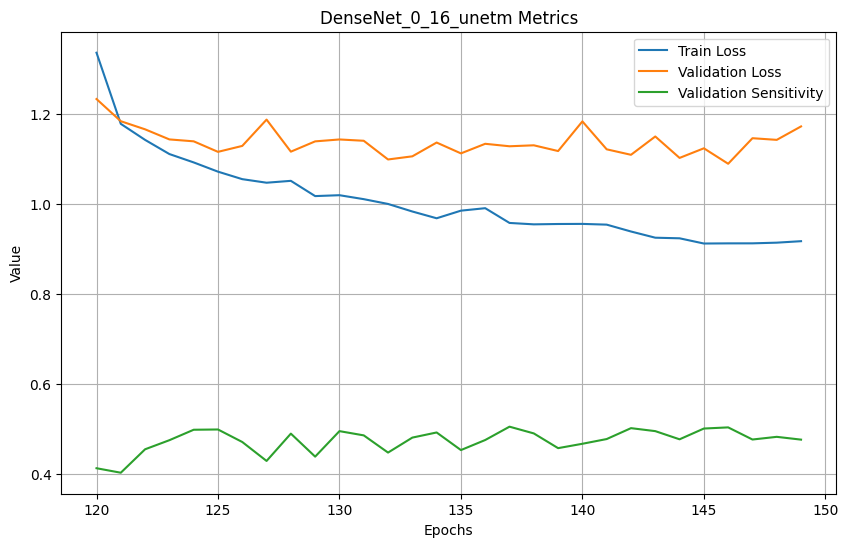

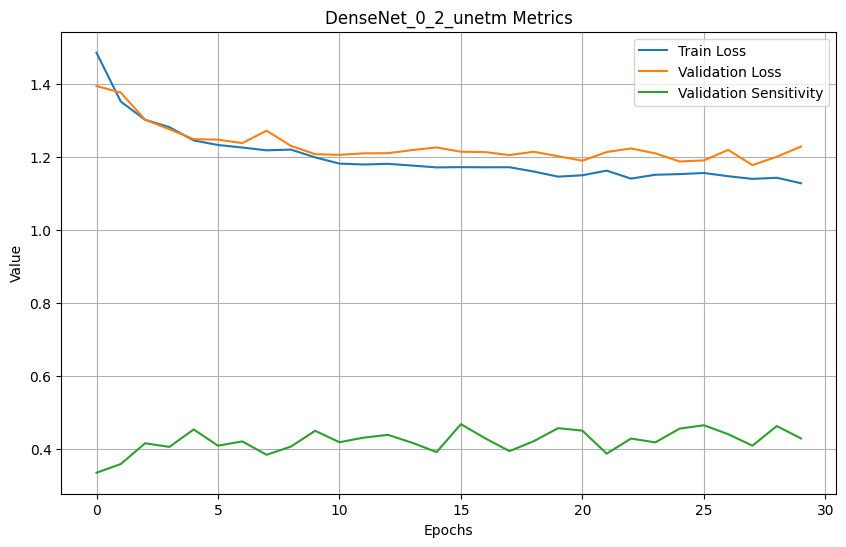

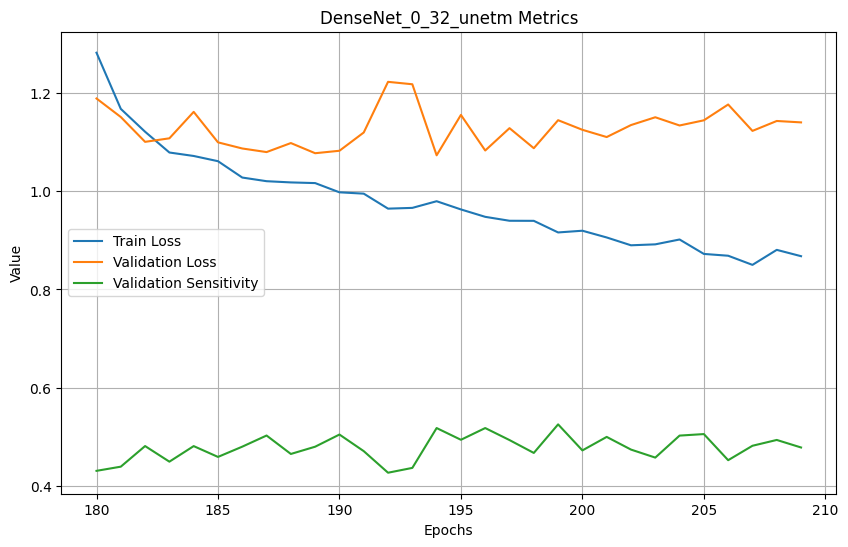

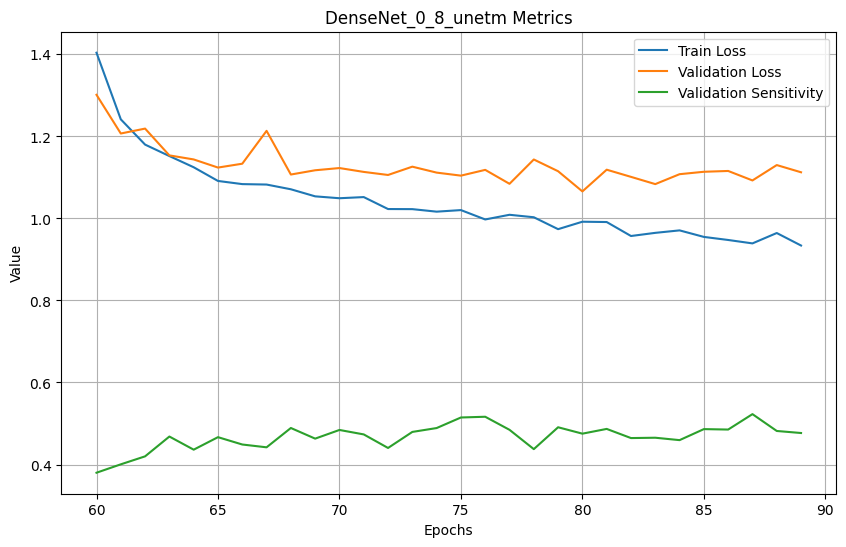

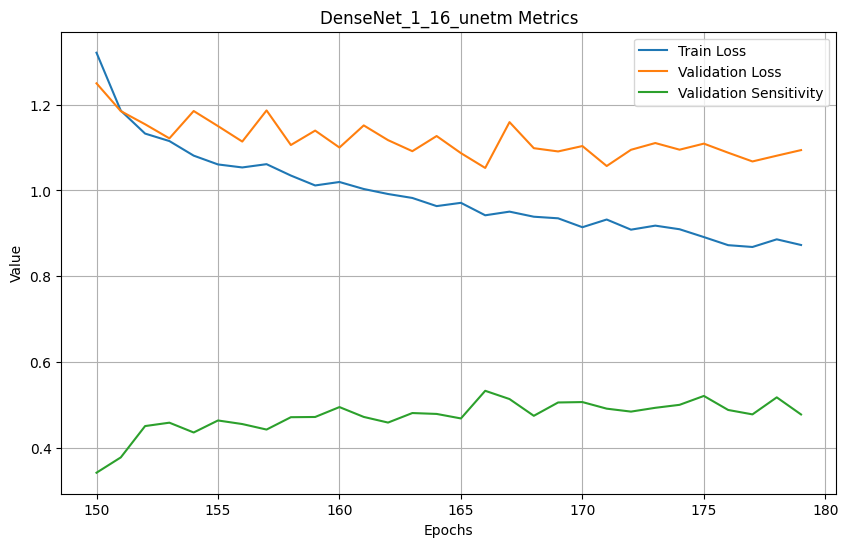

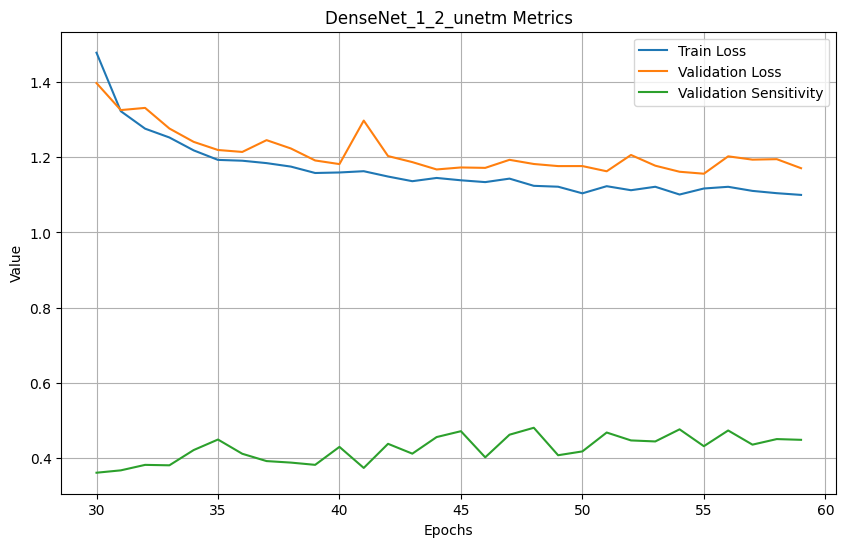

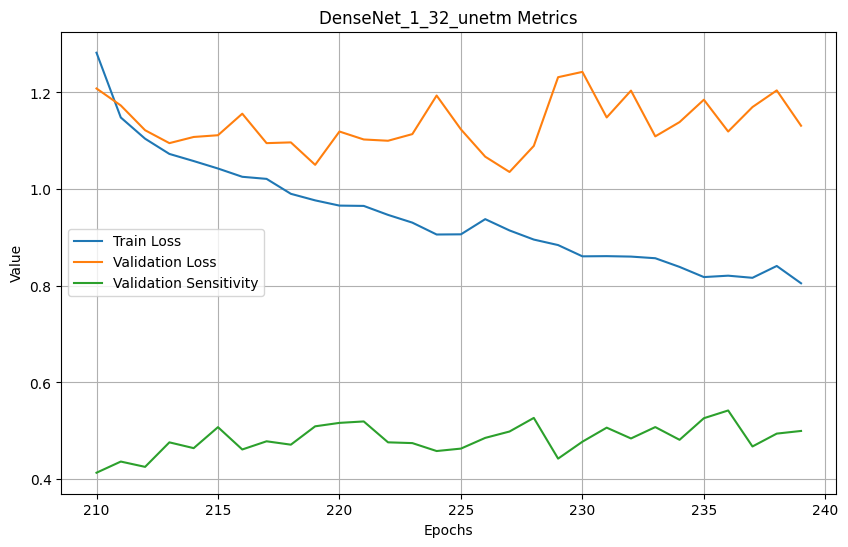

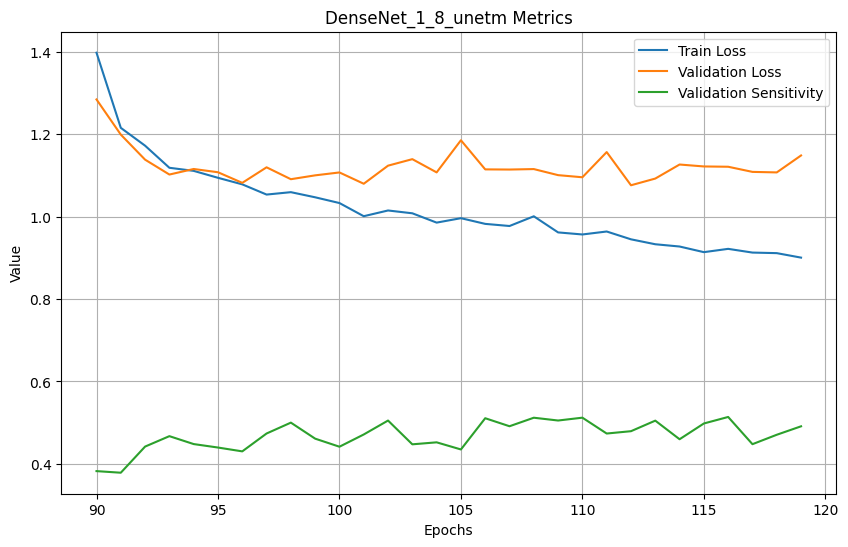

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/densenet_layer_unetm.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
concatenated_outputs = torch.cat((DenseNet_0_2_clahe_outputs, DenseNet_1_32_clahe_outputs), dim=1).cpu().detach().numpy()
true_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, true_labels)

SVC(decision_function_shape='ovo')

In [ ]:
concatenated_outputs = torch.cat((DenseNet_0_2_clahe_outputs, DenseNet_1_32_clahe_outputs), dim=1).cpu().detach().numpy()
true_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, true_labels)

SVC(decision_function_shape='ovo')

### Ben's data

In [49]:
class_weights = calculate_dr_class_weights(ben_train_dataset)

Class Weights: [ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [53]:
layer_list = [[0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("DenseNet", num_first_unfreeze, num_last_unfreeze, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with ben data------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         (224,224),
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_Ben")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/densenet_layer_ben.csv")


-------------Training DenseNet with 0 Unfrozen First Layers and 32 Unfrozen Last Layers with ben data------------


100%|██████████| 137/137 [00:18<00:00,  7.51it/s]


Epoch 1 completed, training loss: 1.1881511224447376
Validation loss: 1.0818158010641734, Validation Accuracy: 54.60, Validation Sensitivty: 0.475431


100%|██████████| 137/137 [00:17<00:00,  7.89it/s]


Epoch 2 completed, training loss: 0.9935523528252205
Validation loss: 1.0028591295083364, Validation Accuracy: 61.10, Validation Sensitivty: 0.559822
Best model saved


100%|██████████| 137/137 [00:17<00:00,  7.92it/s]


Epoch 3 completed, training loss: 0.9354987218432183
Validation loss: 1.0064310431480408, Validation Accuracy: 62.21, Validation Sensitivty: 0.532637


100%|██████████| 137/137 [00:17<00:00,  7.74it/s]


Epoch 4 completed, training loss: 0.8922354561569047
Validation loss: 0.9813921093940735, Validation Accuracy: 59.87, Validation Sensitivty: 0.551955


100%|██████████| 137/137 [00:17<00:00,  7.64it/s]


Epoch 5 completed, training loss: 0.8550577968576528
Validation loss: 0.9881938238938649, Validation Accuracy: 63.49, Validation Sensitivty: 0.542038


100%|██████████| 137/137 [00:17<00:00,  7.67it/s]


Epoch 6 completed, training loss: 0.8283963797301271
Validation loss: 0.9598653137683868, Validation Accuracy: 64.18, Validation Sensitivty: 0.567436
Best model saved


100%|██████████| 137/137 [00:17<00:00,  7.76it/s]


Epoch 7 completed, training loss: 0.8216279605879401
Validation loss: 1.0518880665302277, Validation Accuracy: 69.93, Validation Sensitivty: 0.555428


100%|██████████| 137/137 [00:17<00:00,  7.78it/s]


Epoch 8 completed, training loss: 0.7788672177460942
Validation loss: 1.019366987546285, Validation Accuracy: 68.71, Validation Sensitivty: 0.493720


100%|██████████| 137/137 [00:17<00:00,  7.67it/s]


Epoch 9 completed, training loss: 0.7575533859921197
Validation loss: 0.9849980096022288, Validation Accuracy: 67.11, Validation Sensitivty: 0.516956


100%|██████████| 137/137 [00:17<00:00,  7.75it/s]


Epoch 10 completed, training loss: 0.7302800706268227
Validation loss: 1.0252339323361714, Validation Accuracy: 62.64, Validation Sensitivty: 0.537273


100%|██████████| 137/137 [00:17<00:00,  7.64it/s]


Epoch 11 completed, training loss: 0.7249989400814919
Validation loss: 0.9949381907780965, Validation Accuracy: 53.65, Validation Sensitivty: 0.548472


100%|██████████| 137/137 [00:17<00:00,  7.79it/s]


Epoch 12 completed, training loss: 0.7147842782692317
Validation loss: 1.0003880818684896, Validation Accuracy: 65.83, Validation Sensitivty: 0.562689


100%|██████████| 137/137 [00:17<00:00,  7.91it/s]


Epoch 13 completed, training loss: 0.6693213086058624
Validation loss: 1.026719045639038, Validation Accuracy: 68.44, Validation Sensitivty: 0.534123


100%|██████████| 137/137 [00:17<00:00,  7.75it/s]


Epoch 14 completed, training loss: 0.6700834142465661
Validation loss: 1.0220259050528209, Validation Accuracy: 66.68, Validation Sensitivty: 0.537336


100%|██████████| 137/137 [00:17<00:00,  7.82it/s]


Epoch 15 completed, training loss: 0.6412120448411817
Validation loss: 0.9893531421820323, Validation Accuracy: 62.00, Validation Sensitivty: 0.520153


100%|██████████| 137/137 [00:17<00:00,  7.92it/s]


Epoch 16 completed, training loss: 0.6591110001080227
Validation loss: 0.9885458409786224, Validation Accuracy: 64.29, Validation Sensitivty: 0.554428


100%|██████████| 137/137 [00:17<00:00,  7.98it/s]


Epoch 17 completed, training loss: 0.6333757097268626
Validation loss: 1.0435919135808944, Validation Accuracy: 66.79, Validation Sensitivty: 0.572248
Best model saved


100%|██████████| 137/137 [00:17<00:00,  7.95it/s]


Epoch 18 completed, training loss: 0.6009805872492546
Validation loss: 1.0222746402025222, Validation Accuracy: 63.07, Validation Sensitivty: 0.538419


100%|██████████| 137/137 [00:17<00:00,  7.97it/s]


Epoch 19 completed, training loss: 0.6055810501540664
Validation loss: 1.08731503089269, Validation Accuracy: 65.67, Validation Sensitivty: 0.546270


100%|██████████| 137/137 [00:17<00:00,  7.98it/s]


Epoch 20 completed, training loss: 0.5840369797971127
Validation loss: 1.0906640926996867, Validation Accuracy: 65.46, Validation Sensitivty: 0.529294


100%|██████████| 137/137 [00:17<00:00,  7.84it/s]


Epoch 21 completed, training loss: 0.5721541527849044
Validation loss: 1.0142370939254761, Validation Accuracy: 64.29, Validation Sensitivty: 0.517401


100%|██████████| 137/137 [00:17<00:00,  7.69it/s]


Epoch 22 completed, training loss: 0.5692662859920168
Validation loss: 1.0804088314374287, Validation Accuracy: 66.68, Validation Sensitivty: 0.521175


100%|██████████| 137/137 [00:17<00:00,  7.88it/s]


Epoch 23 completed, training loss: 0.580909013748169
Validation loss: 1.027730875213941, Validation Accuracy: 63.54, Validation Sensitivty: 0.561099


100%|██████████| 137/137 [00:17<00:00,  7.90it/s]


Epoch 24 completed, training loss: 0.5397818873833565
Validation loss: 0.9943051000436147, Validation Accuracy: 63.54, Validation Sensitivty: 0.593107
Best model saved


100%|██████████| 137/137 [00:17<00:00,  7.83it/s]


Epoch 25 completed, training loss: 0.5446167266281852
Validation loss: 1.0311216433842978, Validation Accuracy: 65.67, Validation Sensitivty: 0.556395


100%|██████████| 137/137 [00:17<00:00,  7.88it/s]


Epoch 26 completed, training loss: 0.5419602644269483
Validation loss: 1.083168046673139, Validation Accuracy: 67.59, Validation Sensitivty: 0.557033


100%|██████████| 137/137 [00:17<00:00,  7.84it/s]


Epoch 27 completed, training loss: 0.5384508895612982
Validation loss: 1.0732866485913595, Validation Accuracy: 67.06, Validation Sensitivty: 0.534576


100%|██████████| 137/137 [00:17<00:00,  7.87it/s]


Epoch 28 completed, training loss: 0.5092176255518502
Validation loss: 1.1526335457960764, Validation Accuracy: 68.92, Validation Sensitivty: 0.534671


100%|██████████| 137/137 [00:17<00:00,  7.97it/s]


Epoch 29 completed, training loss: 0.4950950948426323
Validation loss: 1.2696134388446807, Validation Accuracy: 65.73, Validation Sensitivty: 0.529038


100%|██████████| 137/137 [00:17<00:00,  7.99it/s]


Epoch 30 completed, training loss: 0.4992348140608655
Validation loss: 1.161391544342041, Validation Accuracy: 60.51, Validation Sensitivty: 0.561648
-------------Training DenseNet with 1 Unfrozen First Layers and 32 Unfrozen Last Layers with ben data------------


100%|██████████| 137/137 [00:25<00:00,  5.32it/s]


Epoch 1 completed, training loss: 1.2269949695489701
Validation loss: 1.0525915602842966, Validation Accuracy: 58.17, Validation Sensitivty: 0.521345


100%|██████████| 137/137 [00:25<00:00,  5.34it/s]


Epoch 2 completed, training loss: 1.0039105611125918
Validation loss: 1.0000146051247916, Validation Accuracy: 57.96, Validation Sensitivty: 0.517651


100%|██████████| 137/137 [00:26<00:00,  5.16it/s]


Epoch 3 completed, training loss: 0.9239243099289219
Validation loss: 1.0748999436696371, Validation Accuracy: 56.41, Validation Sensitivty: 0.480944


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 4 completed, training loss: 0.8851852869465403
Validation loss: 0.9988706052303314, Validation Accuracy: 66.79, Validation Sensitivty: 0.520879


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 5 completed, training loss: 0.8713410309631459
Validation loss: 1.018249781926473, Validation Accuracy: 59.50, Validation Sensitivty: 0.505996


100%|██████████| 137/137 [00:27<00:00,  4.98it/s]


Epoch 6 completed, training loss: 0.8301029494644081
Validation loss: 1.1734112878640492, Validation Accuracy: 53.49, Validation Sensitivty: 0.473737


100%|██████████| 137/137 [00:27<00:00,  5.01it/s]


Epoch 7 completed, training loss: 0.8006174042277092
Validation loss: 1.0325002690156302, Validation Accuracy: 63.07, Validation Sensitivty: 0.519634


100%|██████████| 137/137 [00:27<00:00,  5.05it/s]


Epoch 8 completed, training loss: 0.811166495519833
Validation loss: 0.9871095438798269, Validation Accuracy: 58.70, Validation Sensitivty: 0.549819
Best model saved


100%|██████████| 137/137 [00:25<00:00,  5.28it/s]


Epoch 9 completed, training loss: 0.7811493401544808
Validation loss: 1.0147113084793091, Validation Accuracy: 59.29, Validation Sensitivty: 0.528704


100%|██████████| 137/137 [00:26<00:00,  5.20it/s]


Epoch 10 completed, training loss: 0.742188242012567
Validation loss: 1.1075192908445994, Validation Accuracy: 70.78, Validation Sensitivty: 0.521966


100%|██████████| 137/137 [00:26<00:00,  5.10it/s]


Epoch 11 completed, training loss: 0.725407863620424
Validation loss: 1.176678514480591, Validation Accuracy: 68.81, Validation Sensitivty: 0.500074


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 12 completed, training loss: 0.718914135529177
Validation loss: 0.9871270438035329, Validation Accuracy: 62.16, Validation Sensitivty: 0.543288


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 13 completed, training loss: 0.6727124200250111
Validation loss: 1.1640931804974874, Validation Accuracy: 67.54, Validation Sensitivty: 0.507861


100%|██████████| 137/137 [00:25<00:00,  5.29it/s]


Epoch 14 completed, training loss: 0.7052739036344263
Validation loss: 1.1731501320997875, Validation Accuracy: 64.02, Validation Sensitivty: 0.485288


100%|██████████| 137/137 [00:25<00:00,  5.32it/s]


Epoch 15 completed, training loss: 0.6706923631420971
Validation loss: 1.3403675129016241, Validation Accuracy: 54.55, Validation Sensitivty: 0.411295


100%|██████████| 137/137 [00:26<00:00,  5.27it/s]


Epoch 16 completed, training loss: 0.6695961806460888
Validation loss: 1.0443944652875266, Validation Accuracy: 61.89, Validation Sensitivty: 0.548366


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 17 completed, training loss: 0.6254642990818859
Validation loss: 1.0752801954746247, Validation Accuracy: 69.03, Validation Sensitivty: 0.549670


100%|██████████| 137/137 [00:25<00:00,  5.29it/s]


Epoch 18 completed, training loss: 0.6273007780095957
Validation loss: 1.073598861694336, Validation Accuracy: 66.31, Validation Sensitivty: 0.573000
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.16it/s]


Epoch 19 completed, training loss: 0.6273717936808175
Validation loss: 1.1480496009190877, Validation Accuracy: 66.26, Validation Sensitivty: 0.520049


100%|██████████| 137/137 [00:26<00:00,  5.27it/s]


Epoch 20 completed, training loss: 0.5991414944185828
Validation loss: 1.1156863768895466, Validation Accuracy: 60.83, Validation Sensitivty: 0.546072


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 21 completed, training loss: 0.5879226668472708
Validation loss: 1.0931811809539795, Validation Accuracy: 65.94, Validation Sensitivty: 0.517735


100%|██████████| 137/137 [00:25<00:00,  5.29it/s]


Epoch 22 completed, training loss: 0.5727665737597611
Validation loss: 1.113376792271932, Validation Accuracy: 66.79, Validation Sensitivty: 0.509250


100%|██████████| 137/137 [00:26<00:00,  5.20it/s]


Epoch 23 completed, training loss: 0.5538206111340627
Validation loss: 1.1178717533747355, Validation Accuracy: 69.29, Validation Sensitivty: 0.560544


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 24 completed, training loss: 0.5452409643326362
Validation loss: 1.186335642139117, Validation Accuracy: 64.72, Validation Sensitivty: 0.597552
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.27it/s]


Epoch 25 completed, training loss: 0.5535423820906312
Validation loss: 1.2720764100551605, Validation Accuracy: 68.28, Validation Sensitivty: 0.519022


100%|██████████| 137/137 [00:26<00:00,  5.20it/s]


Epoch 26 completed, training loss: 0.5243976908008547
Validation loss: 1.3225178877512613, Validation Accuracy: 71.05, Validation Sensitivty: 0.523056


100%|██████████| 137/137 [00:26<00:00,  5.16it/s]


Epoch 27 completed, training loss: 0.5166060820113133
Validation loss: 1.0920869131882986, Validation Accuracy: 64.24, Validation Sensitivty: 0.550151


100%|██████████| 137/137 [00:26<00:00,  5.16it/s]


Epoch 28 completed, training loss: 0.5231939978408118
Validation loss: 1.29136234720548, Validation Accuracy: 59.45, Validation Sensitivty: 0.542483


100%|██████████| 137/137 [00:26<00:00,  5.19it/s]


Epoch 29 completed, training loss: 0.5219131112098694
Validation loss: 1.1704447001218796, Validation Accuracy: 65.19, Validation Sensitivty: 0.513556


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 30 completed, training loss: 0.490341441692227
Validation loss: 1.35018785794576, Validation Accuracy: 73.12, Validation Sensitivty: 0.512800


In [54]:
layer_list = [[0, 32],
              [1, 32]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_Ben_best.pt')
    last_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_Ben_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with clahe data------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        (224,224),
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        (224,224),
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

-------------Evaluating DenseNet with 0 Unfrozen First Layers and 32 Unfrozen Last Layers with clahe data------------
Best Model - Test Loss: 0.874461152156194, Test Accuracy: 64.50239489089941, Test Sensitivity: 0.565082425104634
Last Model - Test Loss: 0.9903285880883534, Test Accuracy: 59.819052687599786, Test Sensitivity: 0.5599918760973613

-------------Evaluating DenseNet with 1 Unfrozen First Layers and 32 Unfrozen Last Layers with clahe data------------
Best Model - Test Loss: 0.8414779166380565, Test Accuracy: 64.71527408195848, Test Sensitivity: 0.5427506731144552
Last Model - Test Loss: 0.6996763110160827, Test Accuracy: 73.44332091538051, Test Sensitivity: 0.4758139014527361



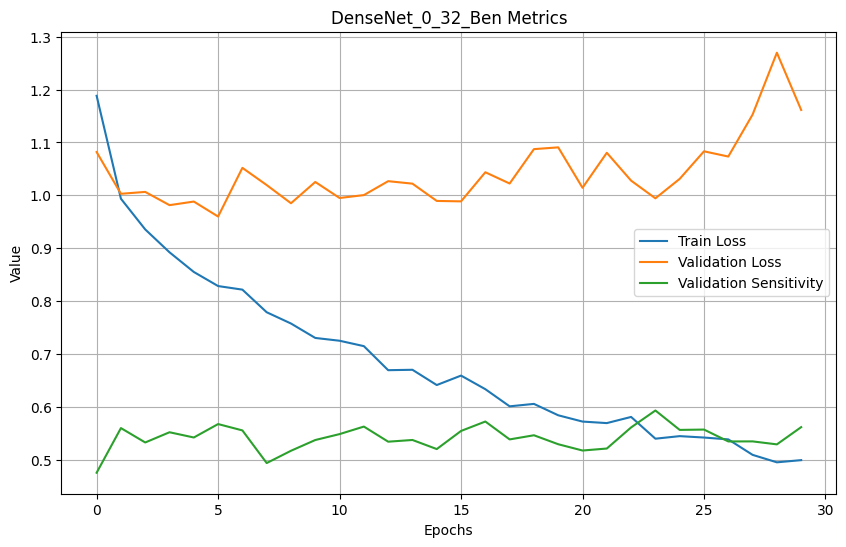

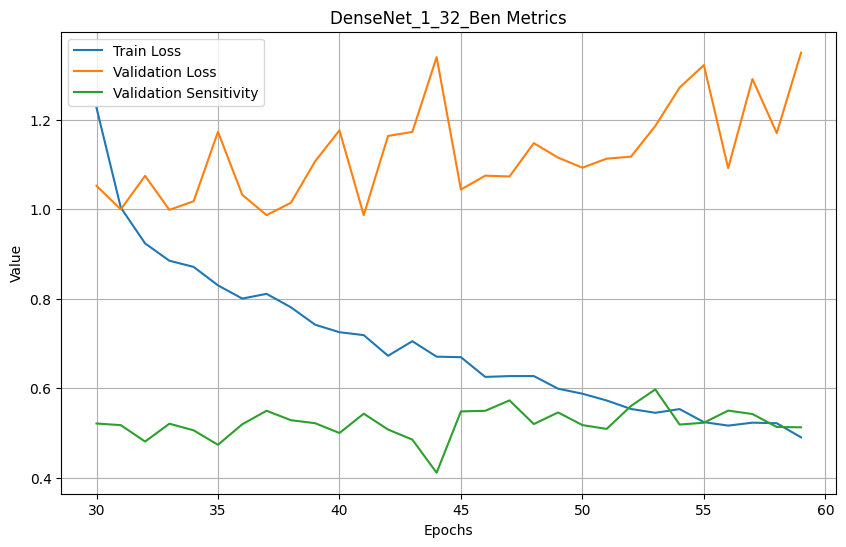

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/densenet_layer_ben.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
